In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import yaml

from data.sirst import IRSTD1kDataset, NUDTDataset

from utils.grad_expand_utils import *
from utils.adaptive_filter import *
from utils.utils import compute_weighted_mean_variance, keep_negative_by_top2_magnitude_levels, \
    add_uniform_points_v3

In [30]:
# cfg
cfg_path = './cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

# # dataset
file_name = '_target'

# trainset = NUDTDataset(base_dir=r"W:/DataSets/ISTD/NUDT-SIRST", mode="train", base_size=256, pt_label=True, \
#                         pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
# img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images" 
# elif args.dataset == 'sirstaug':
#     trainset = SirstAugDataset(base_dir=r'./datasets/sirst_aug',
#                                mode='train', base_size=args.base_size)  # base_dir=r'E:\ztf\datasets\sirst_aug'
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=True, \
                            pseudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"
    
    
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
# # ================== 2. 初始化统计变量（定义在循环外，实现持续性统计）==================
# num_bins = 100
# histogram = torch.zeros(num_bins, dtype=torch.int64)  # 用于累计每个区间的计数

# # 区间边界：[0.0, 0.01), [0.01, 0.02), ..., [0.99, 1.0]
# bin_edges = torch.linspace(0.0, 1.0, steps=num_bins + 1)  # 101 个点，划分 100 个区间

# global histogram

# img_gradient_1 = (img_gradient_1 - img_gradient_1.min())/(img_gradient_1.max() - img_gradient_1.min() + 1e-11)
# img_gradient_2 = (img_gradient_2 - img_gradient_2.min())/(img_gradient_2.max() - img_gradient_2.min() + 1e-11)
# img_gradient_3 = (img_gradient_3 - img_gradient_3.min())/(img_gradient_3.max() - img_gradient_3.min() + 1e-11)
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_1, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_2, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_3, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()

In [77]:
def gradient_expand_one_size(region, scale_weight=[0.5, 0.5, 0.5], target_mask=None, alpha=0.5, beta=0.8, view=False):
    # 归一化区域像素，以形成更强烈的边缘
    region_ = (region - region.min())/(region.max() - region.min())
    # 梯度形成
    img_gradient_1 = img_gradient2(region_)  # 2*2 sober
    img_gradient_2 = img_gradient3(region_)  # 3*3 sober
    img_gradient_3 = img_gradient5(region_)  # 5*5 sobel
    
    # 梯度映射，突出中灰度的区分度
    img_gradient_1, img_gradient_2, img_gradient_3 = sigmoid_mapping3(img_gradient_1, 10), \
         sigmoid_mapping3(img_gradient_2, 10), sigmoid_mapping3(img_gradient_3, 10)
    # 多尺度融合
    img_gradient_ = grad_multi_scale_fusion(img_gradient_1, scale_weight[0]) * grad_multi_scale_fusion(img_gradient_2, scale_weight[0]) * \
        grad_multi_scale_fusion(img_gradient_3, scale_weight[0])
    # 使用target_mask来增强对应区域的梯度
    if target_mask is not None:
        img_gradient_ = alpha + (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11) * (1 - alpha)   # 变换
        target_mask = beta + (target_mask - target_mask.min())/(target_mask.max() - target_mask.min() + 1e-11) * (1 - beta)
        img_gradient_ = img_gradient_ * target_mask.unsqueeze(0).unsqueeze(0)   # (1,24,H,W) *(1,1,H,W)
    img_gradient_ = (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11)

    # 用单像素宽度的梯度替代模糊边缘的宽的梯度
    grad_mask = local_max_gradient(img_gradient_)
    img_gradient_4 = grad_mask * img_gradient_

    # 扩展梯度
    grad_boundary = boundary4gradient_expand(img_gradient_4, 1e3)
    expanded_grad = img_gradient_4
    region_size = region.shape[2] if region.shape[2] > region.shape[3] else region.shape[3]
    for z in range(region_size):
        expanded_grad_ = gradient_expand_one_step(expanded_grad)
        expanded_grad_ += grad_boundary
        expanded_grad_ = torch.where(expanded_grad > expanded_grad_, expanded_grad, expanded_grad_) * (expanded_grad_ > -1e-4)
        expanded_grad = expanded_grad_

        # for show
        target_angle_idx = 1
        expand0 = expanded_grad[:,target_angle_idx].clone()
        grad_0 = (img_gradient_4[:,target_angle_idx].clone()).float()
        grad_12 = (img_gradient_4[:,target_angle_idx+12].clone()).float()
        expand0 = torch.clamp_min(expand0, 0)
        pict_rgb = torch.cat([grad_12 + expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001), expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001), expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001) + grad_0])
        plt.figure(figsize=(5, 5))
        plt.imshow(pict_rgb.permute(1,2,0))
        # plt.imshow(grad_expand[0,12], cmap='gray')
        plt.show()
        a = input()

    # # for show
    # # target_angle_idx = 1
    # # expand0 = expanded_grad[:,target_angle_idx].clone()
    # # grad_0 = (img_gradient_4[:,target_angle_idx].clone() > 0.1).float()
    # # grad_12 = (grad_boundary[:,target_angle_idx].clone() * -1e-3 > 0.1).float()
    # # expand0 = torch.clamp_min(expand0, 0)
    # # pict_rgb = torch.cat([expand0+grad_12, expand0,expand0+grad_0])
    # plt.figure(figsize=(5, 5))
    # # plt.imshow(pict_rgb.permute(1,2,0))
    # plt.imshow(expanded_grad[0,0], cmap='gray')
    # plt.show()

    # # plt.figure(figsize=(5, 5))
    # # plt.imshow(expanded_grad[0, 2], cmap='gray')
    # # plt.show()

    _target = torch.sum(expanded_grad[0], dim=0)
    _target = (_target - _target.min())/(_target.max() - _target.min())

    _expanded_grad = (expanded_grad - expanded_grad.min())/(expanded_grad.max() - expanded_grad.min())

    return _target, img_gradient_4

In [78]:
def initial_target(grad_intensity: torch.Tensor, pt_label: torch.Tensor, threshold: float = 0.1):
        """
        Args:
            grad_intensity: 输入图像 [H, W]
            threshold: 阈值，用于初步划分种子点是否为有效种子点，如前景种子点需>threshold，背景种子点需<threshold
        Returns:
            seed_cofidence: 概率图 [H, W, 2]
        """
        H, W = grad_intensity.shape

        # 找局部最高值，再梯度强度➗局部最大值，进行局部归一化
        local_max = F.max_pool2d(grad_intensity.unsqueeze(0).unsqueeze(0), (5,5), stride=1, padding=2)
        local_norm_GI = grad_intensity / (local_max + 1e-11)

        # 局部最大值
        local_max2 = F.max_pool2d(local_norm_GI, (3,3), stride=1, padding=1)
        summit_mask = (local_norm_GI == local_max2)
        local_norm_GI = local_norm_GI.squeeze(0).squeeze(0)
        summit_mask = summit_mask.squeeze(0).squeeze(0)

        fg_area = (grad_intensity > threshold).float()
        bg_area = (grad_intensity < 0.1).float()

        noise_ratio = 0.05
        converge_time = 0
        for iter1 in range(50):
            fg_mask = add_uniform_points_v3(grad_intensity, fg_area > 0.1, torch.zeros_like(fg_area, dtype=torch.bool), 9, mode='bg')
            bg_mask = add_uniform_points_v3(grad_intensity, bg_area > 0.1, torch.zeros_like(bg_area, dtype=torch.bool), int(9 * bg_area.sum()/fg_area.sum()), mode='bg')
            for iter2 in range(100):
                noise = torch.rand(grad_intensity.shape)
                GI = grad_intensity * (1-noise_ratio) + noise * noise_ratio
                fig = plt.figure(figsize=(20, 5))
                # plt.subplot(1, 7, 1)
                # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 2)
                # plt.imshow(fg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 3)
                # plt.imshow(bg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)

                max_num = np.ceil(fg_mask.sum().item())
                min_num = np.ceil(bg_mask.sum().item())

                if max_num > 3 and min_num > 5:
                    fg_ratio = 1 - max_num /(fg_area.sum() + 1e-8)
                    bg_ratio = 1 - min_num /(bg_area.sum() + 1e-8)
                    fg_ratio = max(fg_ratio, 0.20)
                    bg_ratio = max(bg_ratio, 0.20)

                    local_max_num = 4 if max_num * fg_ratio < 4 else max_num * fg_ratio
                    _, fg_vwo, _, fg_v = compute_weighted_mean_variance(GI, fg_mask > 0.1, int(local_max_num))

                    local_min_num = 6 if min_num * bg_ratio < 6 else min_num * bg_ratio
                    _, bg_vwo, _, bg_v = compute_weighted_mean_variance(GI, bg_mask > 0.1, int(local_min_num))
                    # print(local_max_num, local_min_num)
                    result_ = fg_v/(fg_vwo+1e-8) - bg_v/(bg_vwo+1e-8)   #(H,W)
                    # result_ = keep_negative_by_top2_magnitude_levels(result_)

                    # print(GI)
                    # print("result_")
                    # print(result_)
                    # print(fg_vwo)
                    # print(bg_vwo)
                    # print((fg_v/(fg_vwo+1e-8) - 1))
                    # print((bg_v/(bg_vwo+1e-8) - 1))

                    # plt.subplot(1, 7, 4)
                    # plt.imshow((bg_v/(bg_vwo+1e-8)-1), cmap='gray')
                    # plt.subplot(1, 7, 5)
                    # plt.imshow((fg_v/(fg_vwo+1e-8)-1), cmap='gray')
                    # plt.title(f'max{bg_vwo.max():3e}, min{bg_vwo.min():3e}')

                    # plt.subplot(1, 4, 1)
                    # plt.imshow(fg_mask, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 2)
                    # plt.imshow(bg_mask, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')

                    # plt.subplot(1, 4, 3)
                    # plt.imshow(bg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 4)
                    # plt.imshow(fg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.show()
                    # a = input()
                else:
                    result_ = torch.where(fg_area > 0.1, -GI, GI)
                result_ = keep_negative_by_top2_magnitude_levels(result_, target_size=fg_area.sum())
                result = torch.where(result_ < 0., torch.ones_like(GI), torch.zeros_like(GI)).bool()
                # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()


                fg_seed_num = int(0.1*max_num)
                fg_seed_num = fg_seed_num if fg_seed_num > 2 else 2
                # if fitted != 1:
                fg_mask_new = add_uniform_points_v3(GI, (fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num), mode='fg')
                # else:
                # fg_mask_new = add_uniform_points_cuda((fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num))
                fg_mask_new = fg_mask_new.bool() * result

                bg_seed_num = int(0.1*min_num)
                bg_seed_num = bg_seed_num if bg_seed_num > 8 else 8
                # if fitted != 1:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = add_uniform_points_v3(GI, (bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num), mode='bg')
                # else:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ > 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = bg_mask_new.bool() * ~result

                diff = torch.norm(fg_mask_new.float() - (fg_mask > 0.1).float()) 
                if diff < 1:
                    # print(f"iter1 {iter1} iter2 Converged at {iter2}")
                    break
                # else:
                #     print(f"iter1 {iter1} iter2 {iter2}, Diff: {diff}")

                plt.subplot(1, 4, 3)
                plt.imshow(fg_mask_new, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.imshow(result, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.imshow(bg_mask_new, cmap='gray'),  plt.axis('off')
                plt.show()
                a = input()

                decay_rate = 0.8
                fg_mask, bg_mask = fg_mask_new.float() + fg_mask*decay_rate, bg_mask_new.float() + bg_mask*decay_rate
                fg_mask, bg_mask = torch.clamp(fg_mask, min=0.0, max=1.0), torch.clamp(bg_mask, min=0.0, max=1.0)
            
            # fig = plt.figure(figsize=(15, 5))
            # plt.subplot(1, 3, 1)
            # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 2)
            # plt.imshow(result, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 3)
            # plt.imshow(fg_area, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.show(block=False)
            # a = input()
            # 修改area
            # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()
            # print(f"iter2 Converged at{iter2}, Diff: {diff}")
            fg_area_new = result
            bg_area_new = ~result
            diff = torch.norm(bg_area_new.float() - bg_area.float())
            if diff < (H * W / 64) ** 0.5:
                converge_time += 1
                # print(f"iter1 Converged at{iter1}, Diff: {diff}")
            if converge_time > 3:
                break
            # else:
            #     print(f"iter1 {iter1}, Diff: {diff}")
            if result.float().sum() < 4:
                noise_ratio = noise_ratio * 0.5
                continue
            noise_ratio = noise_ratio * 0.9
            if fg_area_new.sum() > (grad_intensity > 0.1).float().sum() * 2 and (H + W) > 96:
                break
            decay_rate = 0.5
            fg_area, bg_area = fg_area_new.float() + fg_area*decay_rate, bg_area_new.float()+ bg_area*decay_rate
            fg_area, bg_area = torch.clamp(fg_area, min=0.0, max=1.0), torch.clamp(bg_area, min=0.0, max=1.0)

        return result

In [79]:
def gradient_expand_filter_v2(img, pt_label, region_size, view=False):
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)
    output = torch.zeros_like(img, dtype=torch.float32)
    for b, _, s1, s2 in zip(*indices):
        # 提取区域
        targets = []
        for i in range(len(region_size)):
            _region_size = region_size[i]
            # 计算区域坐标（y1, x1)(y2, x2)
            y1 = max(1, s1 - _region_size // 2)
            x1 = max(1, s2 - _region_size // 2)
            y2 = min(H-1, s1 + (_region_size - _region_size // 2))
            x2 = min(W-1, s2 + (_region_size - _region_size // 2))
            _region = img[b:b+1,:1, y1:y2, x1:x2]

            _target, grad_expand = gradient_expand_one_size(_region, [0.5, 0.5, 0.5], view=view)
            targets.append({'target':_target, 'coor':(y1,x1,y2,x2)})

            # _target_fg = torch.where(_target > 0.5, torch.tensor([1.,]), torch.tensor([0.,]))
            # _target_bg = torch.where(_target < 0.1, torch.tensor([-1.,]), torch.tensor([0.,]))
            # target = _target_fg + _target_bg

            # plt.figure(figsize=(5, 5))
            # plt.imshow(target, cmap='gray', vmax=1.0, vmin=-1.0)
            # # plt.imshow(_region[0,0], cmap='gray', vmax=1.0, vmin=-1.0)
            # plt.show()

            # # for show
            # target_angle_idx = 1
            # expand0 = grad_expand[:,target_angle_idx].clone()
            # grad_0 = (grad_expand[:,target_angle_idx].clone()).float()
            # grad_12 = (grad_expand[:,target_angle_idx+12].clone()).float()
            # expand0 = torch.clamp_min(expand0, 0)
            # pict_rgb = torch.cat([grad_12, torch.zeros_like(expand0),grad_0])
            # plt.figure(figsize=(5, 5))
            # plt.imshow(pict_rgb.permute(1,2,0))
            # # plt.imshow(grad_expand[0,12], cmap='gray')
            # plt.show()
        
        # final_target, scores, coors = finalize_target(targets, view)

        # fig = plt.figure(figsize=(15, 5))
        # plt.subplot(1, 3, 1)
        # plt.imshow(final_target, cmap='gray', vmax=1.0, vmin=0.0)
        # plt.subplot(1, 3, 2)
        # plt.imshow(final_target, cmap='gray', vmax=0.1, vmin=0.0)
        # plt.subplot(1, 3, 3)
        # plt.imshow(img[b,0, coors[0]:coors[2], coors[1]:coors[3]], cmap='gray', vmax=1.0, vmin=0.0)
        # plt.show()
        
        # target_filtered__ = initial_target(final_target, pt_label[b,0, coors[0]:coors[2], coors[1]:coors[3]], threshold=0.5)
        # target_filtered_by_points = filter_mask_by_points(target_filtered__, pt_label[b,0, coors[0]:coors[2], coors[1]:coors[3]]) # (uint8)
        # target_refined = target_filtered_by_points
        
        # output[b,0, coors[0]:coors[2], coors[1]:coors[3]] = torch.max(output[b,0, coors[0]:coors[2], coors[1]:coors[3]], target_refined)
    return output

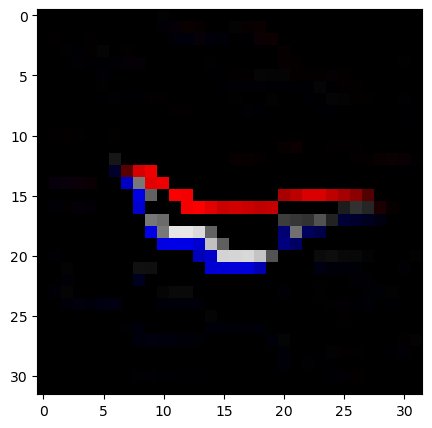

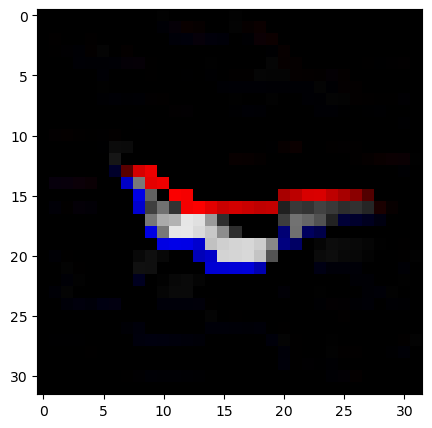

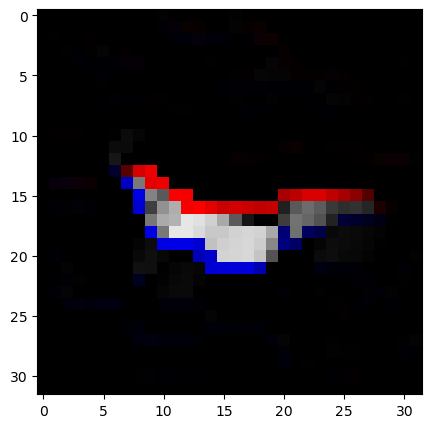

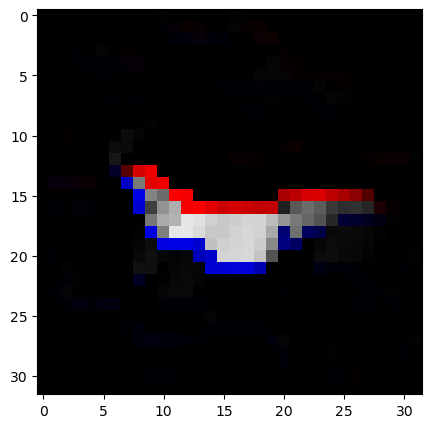

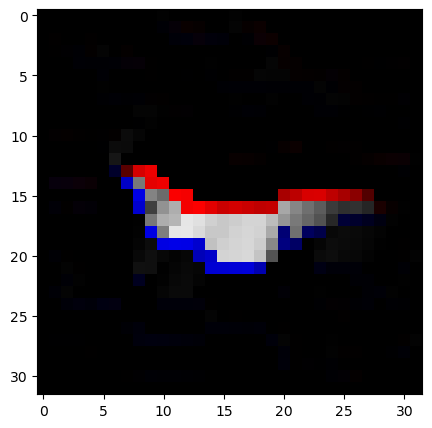

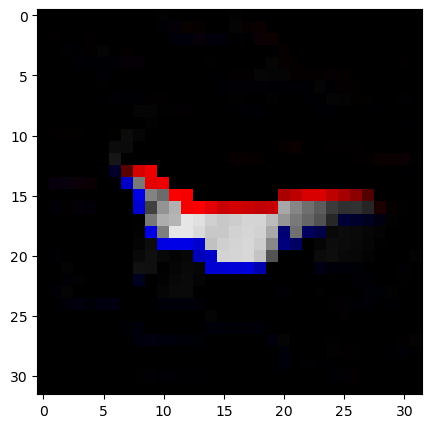

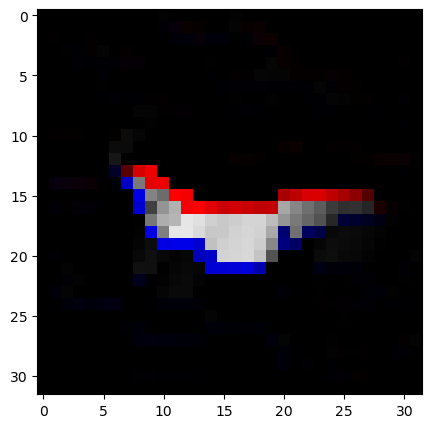

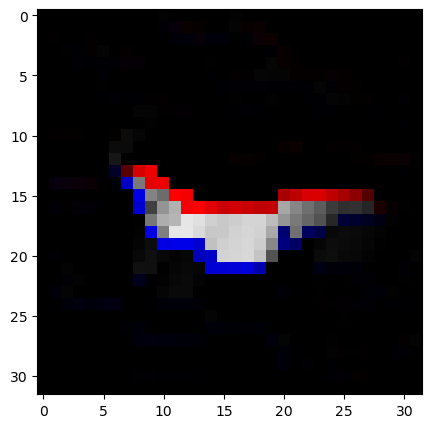

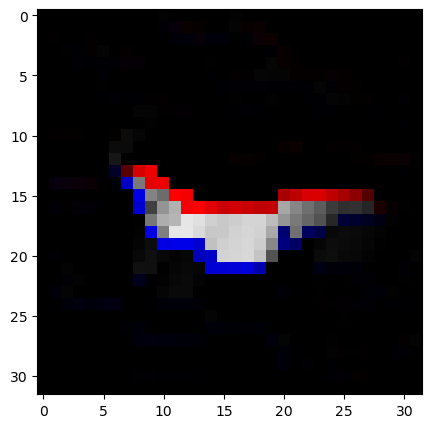

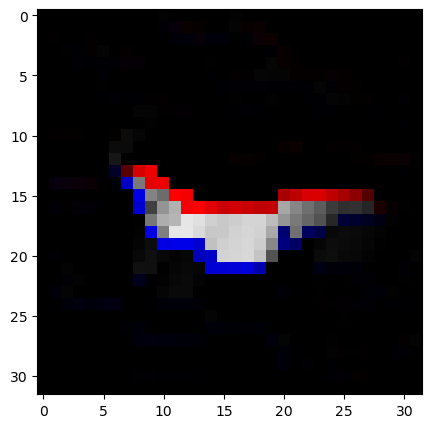

KeyboardInterrupt: Interrupted by user

In [80]:
for j, (img, label) in enumerate(train_data_loader):
    pt_label, pesudo_label = label[:,0:1], label[:,1:2]
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)

    target_grad_expanded_filtered = gradient_expand_filter_v2(img, pt_label, [32,48,64], view=0)


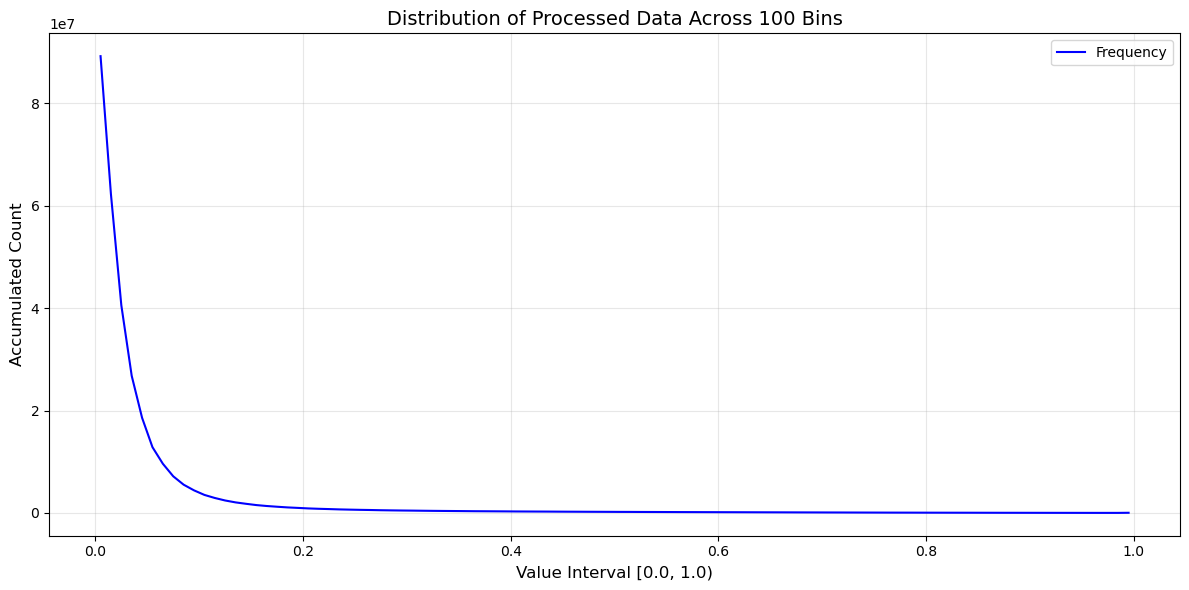

In [19]:
# ================== 4. 绘图 ==================
plt.figure(figsize=(12, 6))
bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 每个区间的中心点作为横坐标
plt.plot(bins_centers.numpy(), histogram.numpy(), color='blue', linewidth=1.5, label='Frequency')
plt.xlabel('Value Interval [0.0, 1.0)', fontsize=12)
plt.ylabel('Accumulated Count', fontsize=12)
plt.title('Distribution of Processed Data Across 100 Bins', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
# ================== 4. 绘图（使用对数坐标轴）==================
plt.figure(figsize=(12, 6))
bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 每个区间的中心

# 绘制折线图
plt.plot(bins_centers.numpy(), histogram.numpy(), 
         color='blue', linewidth=1.5)

# 👇 关键：设置 y 轴为对数刻度
plt.yscale('log')

plt.xlabel('Gradient Intensity [0.0, 1.0)', fontsize=12)
plt.ylabel('Pixel Count (log scale)', fontsize=12)
# plt.title('Distribution of Processed Data Across 100 Bins (Log Scale)', fontsize=14)
plt.grid(True, alpha=0.3, which="both")  # 同时显示主次网格
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


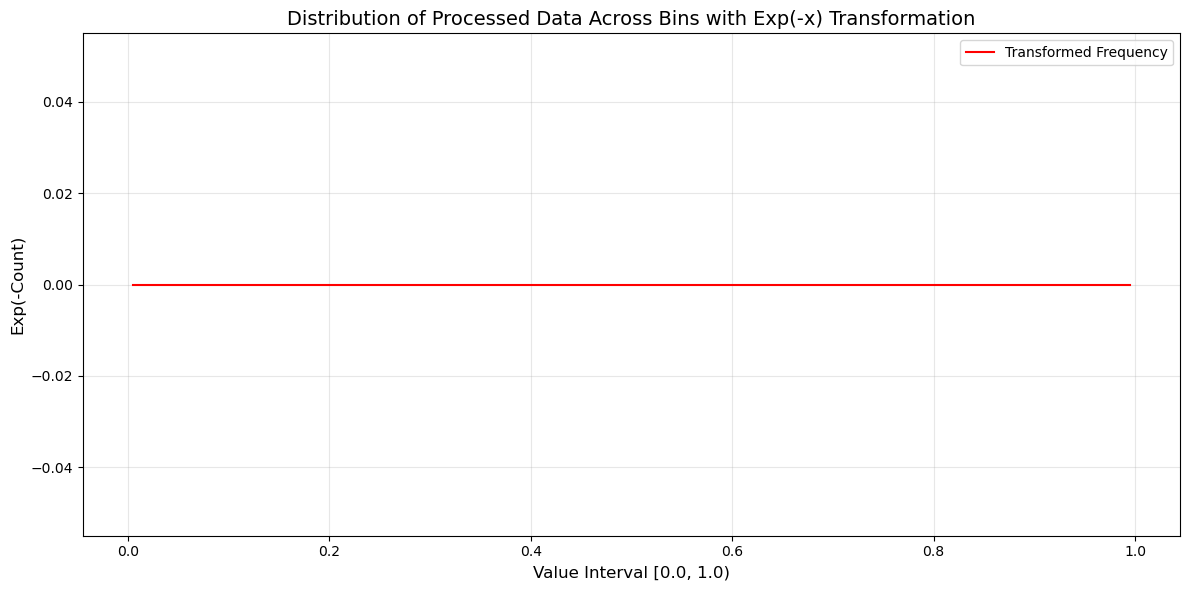

In [24]:
# 对纵坐标进行 y=exp(-x) 处理
transformed_histogram = np.exp(-histogram.numpy())
print(transformed_histogram)

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制折线图
plt.plot(bins_centers, transformed_histogram, color='red', linewidth=1.5, label='Transformed Frequency')

# 设置图表信息
plt.xlabel('Value Interval [0.0, 1.0)', fontsize=12)
plt.ylabel('Exp(-Count)', fontsize=12)
plt.title('Distribution of Processed Data Across Bins with Exp(-x) Transformation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# 显示图表
plt.show()

In [1]:
from PIL import Image
import numpy as np
import os
import os.path as osp

from utils.evaluation import SegmentationMetricTPFNFP

In [4]:
# pesudo_mask_dir = "W:/DataSets/ISTD/NUDT-SIRST/trainval/pixel_pseudo_label4.10_dna"
# mask_dir = "W:/DataSets/ISTD/NUDT-SIRST/trainval/masks"
pesudo_mask_dir = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label0.63"
mask_dir = "W:/DataSets/ISTD/IRSTD-1k/trainval/masks"
names = os.listdir(mask_dir)

metric = SegmentationMetricTPFNFP(nclass=1)

for name in names:
    mask_path = osp.join(mask_dir, name)
    pesudo_mask_path = osp.join(pesudo_mask_dir, name)

    mask = Image.open(mask_path).convert('L')
    # mask = Image.open(mask_path).convert('L').resize((256, 256), Image.NEAREST)
    pesudo_mask = Image.open(pesudo_mask_path).convert('L') 

    mask, pesudo_mask = np.array(mask).astype(np.float32) / 255., np.array(pesudo_mask).astype(np.float32) / 255.
    # pesudo_mask 设置阈值使得其为二值图
    pesudo_mask = (pesudo_mask >= 0.25).astype(np.float32)
    
    metric.update(mask, pesudo_mask)

base_log = "pesudo_mask quality, mIoU: {:.4f}, prec: {:.4f}, recall: {:.4f}, F1: {:.4f} "
iou , prec, recall, f1 = metric.get()
print(base_log.format(iou , prec, recall, f1))

pesudo_mask quality, mIoU: 0.6326, prec: 0.8462, recall: 0.7148, F1: 0.7749 


In [2]:
np.load("W:/Projects/WeakSupervisedIRSTD/others_pseudo_label_g/SIRST-Single-Point-Supervision-main/dataset/final_dataset_final/NUAA-SIRST/image_info/Misc_1.npy", allow_pickle=True)

array({'name': 'Misc_1', 'Ymin_f': [69, 129], 'Ymax_f': [79, 138], 'Xmin_f': [67, 216], 'Xmax_f': [73, 223], 'centroid_label_y': [74, 133], 'centroid_label_x': [70, 220], 'target_type': ['Point', 'Point']},
      dtype=object)

In [6]:
screenshot_path = 'picts/page010_img005.png'
# 读取并二值化
img = Image.open(screenshot_path).convert('L')
arr = np.array(img)
# mask = (arr > 127).astype(np.uint8)  # 转为 0/1
h, w = mask.shape

In [ ]:
for i in range(100):
    if arr[i,200] > 1:
        print(i)
        break
for j in range(100):
    if arr[200,j] > 1:
        print(j)
        break
for m in range(100, 1000):
    if arr[m,200] < 1:
        print(m)
        break
for n in range(100, 1000):
    if arr[200,n] < 1:
        print(n)
        break
coors = [i, m, j, n]

for p in range()

29
29
855
711


In [13]:
np.sum(arr[:29,200])

0

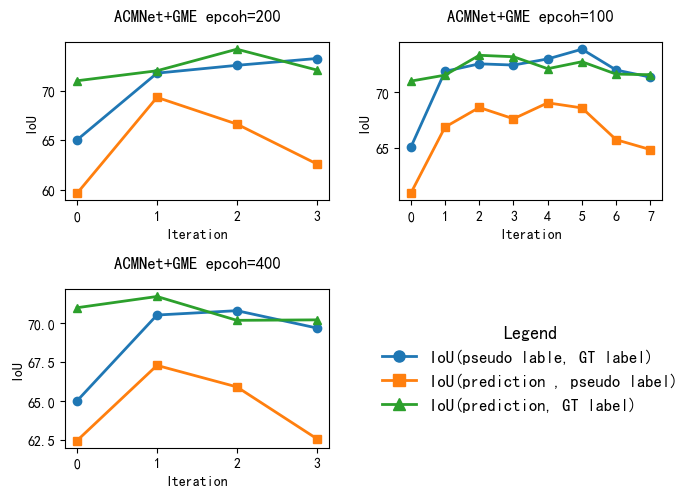

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和图形尺寸
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 9)

# 模拟数据：3个子图，每个子图3条线
iters1 = np.arange(0, 4)
iters2 = np.arange(0, 8)
iters3 = np.arange(0, 4)

# 子图1的数据 (销售额)
sales_A = np.array([65.04, 71.78, 72.57, 73.26])
sales_B = np.array([59.64, 69.33, 66.63, 62.61])
sales_C = np.array([71.01, 72.02, 74.2, 72.1])


# 子图2的数据 (用户数)
# users_A = np.array([65.04, 70.28, 70.96, 68.92])
# users_B = np.array([57.13, 69.7, 54.66, 57.51])
# users_C = np.array([65.01, 70.14, 71.51, 69.79])

users_A = np.array([65.04, 71.89, 72.57, 72.46, 73.01, 73.89, 72.01, 71.37])
users_B = np.array([60.89, 66.86, 68.63, 67.61, 69.05, 68.59, 65.72, 64.83])
users_C = np.array([71.01, 71.55, 73.34, 73.21, 72.13, 72.76, 71.64, 71.59])

# 子图3的数据 (利润率)
# profit_A = np.array([65.04, 71.93, 73.75, 72.99])
# profit_B = np.array([63.07, 69.6, 64.96, 70.1])
# profit_C = np.array([72.29, 72.62, 73.59, 72.04])

profit_A = np.array([65.04, 70.54, 70.82, 69.71])
profit_B = np.array([62.49, 67.31, 65.93, 62.61])
profit_C = np.array([71.01, 71.73, 70.2, 70.23])

# 创建2x2子图布局
fig, axs = plt.subplots(2, 2, figsize=(7, 5))
# fig.suptitle('业务指标综合分析报告', fontsize=10, fontweight='bold', y=0.95)

# 为三种类型定义统一的颜色和标记
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['o', 's', '^']  # 圆圈、方块、三角
labels = ['IoU(pseudo lable, GT label)', 'IoU(prediction , pseudo label)', 'IoU(prediction, GT label)']  # 只需3个图例标签

# # 定义颜色方案（确保9条线颜色可区分）
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# 子图1：销售额（左上）
sales_lines = []
sales_lines.append(axs[0, 0].plot(iters1, sales_A, marker='o', markersize=6, linewidth=2, color=colors[0], label=labels[0])[0])
sales_lines.append(axs[0, 0].plot(iters1, sales_B, marker='s', markersize=6, linewidth=2, color=colors[1], label=labels[1])[0])
sales_lines.append(axs[0, 0].plot(iters1, sales_C, marker='^', markersize=6, linewidth=2, color=colors[2], label=labels[2])[0])
# axs[0, 0].set_title('ACMNet+GME', fontsize=14, pad=15)
axs[0, 0].set_title('ACMNet+GME epcoh=200', fontsize=12, pad=15)
axs[0, 0].set_xlabel('Iteration', fontsize=10)
axs[0, 0].set_ylabel('IoU', fontsize=10)
# axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].set_xticks(iters1)

# 子图2：用户数（右上）
user_lines = []
user_lines.append(axs[0, 1].plot(iters2, users_A, marker='o', markersize=6, linewidth=2, color=colors[0], label=labels[0])[0])
user_lines.append(axs[0, 1].plot(iters2, users_B, marker='s', markersize=6, linewidth=2, color=colors[1], label=labels[1])[0])
user_lines.append(axs[0, 1].plot(iters2, users_C, marker='^', markersize=6, linewidth=2, color=colors[2], label=labels[2])[0])
# axs[0, 1].set_title('AGPCNet+GME', fontsize=14, pad=15)
axs[0, 1].set_title('ACMNet+GME epcoh=100', fontsize=12, pad=15)
axs[0, 1].set_xlabel('Iteration', fontsize=10)
axs[0, 1].set_ylabel('IoU', fontsize=10)
# axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].set_xticks(iters2)

# 子图3：利润率（左下）
profit_lines = []
profit_lines.append(axs[1, 0].plot(iters3, profit_A, marker='o', markersize=6, linewidth=2, color=colors[0], label=labels[0])[0])
profit_lines.append(axs[1, 0].plot(iters3, profit_B, marker='s', markersize=6, linewidth=2, color=colors[1], label=labels[1])[0])
profit_lines.append(axs[1, 0].plot(iters3, profit_C, marker='^', markersize=6, linewidth=2, color=colors[2], label=labels[2])[0])
# axs[1, 0].set_title('DNANet+GME', fontsize=14, pad=15)
axs[1, 0].set_title('ACMNet+GME epcoh=400', fontsize=12, pad=15)
axs[1, 0].set_xlabel('Iteration', fontsize=10)
axs[1, 0].set_ylabel('IoU', fontsize=10)
# axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].set_xticks(iters3)

# --- 子图4：统一图例 ---
ax_legend = axs[1, 1]
ax_legend.axis('off')  # 隐藏坐标轴

# 创建图例句柄（只创建3个）
legend_handles = [
    plt.Line2D([0], [0], color=colors[i], marker=markers[i], 
               linestyle='-', linewidth=2, markersize=8, 
               label=labels[i])
    for i in range(3)
]

# 在右下角子图中心放置图例
ax_legend.legend(
    handles=legend_handles,
    loc='center',
    fontsize=12,
    frameon=False,
    fancybox=False,
    shadow=False,
    title='Legend',
    title_fontsize=13
)
# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # 为总标题留出空间

# 显示图形
plt.show()

In [ ]:
import pdfplumber
import pandas as pd

表格已保存到 pdfs/output_plumber.xlsx


In [20]:
pdf_path = "pdfs/PAL.pdf"
output_excel = "pdfs/PAL.xlsx"

all_dfs = []

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        tables = page.extract_tables()
        for table in tables:
            df = pd.DataFrame(table[1:], columns=table[0])  # 假设第一行为表头
            all_dfs.append(df)

# 保存到 Excel
with pd.ExcelWriter(output_excel) as writer:
    for i, df in enumerate(all_dfs):
        df.to_excel(writer, sheet_name=f"Page{page.page_number}_Table{i+1}", index=False)

print(f"表格已保存到 {output_excel}")

Cannot set gray non-stroke color because /'P242' is an invalid float value
Cannot set gray non-stroke color because /'P417' is an invalid float value
Cannot set gray non-stroke color because /'P646' is an invalid float value
Cannot set gray non-stroke color because /'P1414' is an invalid float value
Cannot set gray non-stroke color because /'P2298' is an invalid float value
Cannot set gray non-stroke color because /'P2606' is an invalid float value
Cannot set gray non-stroke color because /'P2732' is an invalid float value
Cannot set gray non-stroke color because /'P2817' is an invalid float value
Cannot set gray non-stroke color because /'P2953' is an invalid float value
Cannot set gray non-stroke color because /'P3144' is an invalid float value
Cannot set gray non-stroke color because /'P3145' is an invalid float value
Cannot set gray non-stroke color because /'P3847' is an invalid float value
Cannot set gray non-stroke color because /'P4796' is an invalid float value
Cannot set gray

表格已保存到 pdfs/PAL.xlsx


In [51]:
from net.ACMnet import ASKCResUNet_withloss
import os
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import yaml

from data.sirst import IRSTD1kDataset, NUDTDataset

from utils.grad_expand_utils import *
from utils.adaptive_filter import *
from utils.utils import compute_weighted_mean_variance, keep_negative_by_top2_magnitude_levels, \
    add_uniform_points_v3

def set_seeds(seed):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(1)
file_name = ""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "result/20250921T15-39-39_acmnet_nudt_3.15_acm"

In [52]:
# save as: sod_visualizer.py
import cv2
from skimage import measure
from typing import List, Tuple, Dict, Optional

def extract_connected_components(mask: np.ndarray) -> List[Dict]:
    """
    输入: 二值掩码 [H, W] (0/1)
    输出: 每个连通区域的 dict: {'bbox': (y1, x1, y2, x2), 'coords': (rows, cols)}
    注意: skimage 的 bbox 是 (min_row, min_col, max_row, max_col)
    """
    labeled = measure.label(mask, connectivity=2)
    regions = measure.regionprops(labeled)
    components = []
    for r in regions:
        if r.area == 0:
            continue
        # bbox: (min_row, min_col, max_row, max_col)
        bbox = r.bbox  # (y1, x1, y2, x2)
        components.append({
            'bbox': bbox,
            'coords': (r.coords[:, 0], r.coords[:, 1])  # (rows, cols)
        })
    return components

def match_predictions_to_labels(
    pred_ccs: List[Dict],
    label_ccs: List[Dict],
    mask_shape: Tuple[int, int]
) -> Dict[str, List]:
    """
    返回:
    - 'tp': list of (pred_idx, label_idx)
    - 'fp': list of pred_idx
    - 'fn': list of label_idx
    """
    H, W = mask_shape
    # 构建 label 掩码集合（用于快速查询）
    label_masks = []
    for comp in label_ccs:
        mask = np.zeros((H, W), dtype=bool)
        rows, cols = comp['coords']
        mask[rows, cols] = True
        label_masks.append(mask)

    pred_masks = []
    for comp in pred_ccs:
        mask = np.zeros((H, W), dtype=bool)
        rows, cols = comp['coords']
        mask[rows, cols] = True
        pred_masks.append(mask)

    tp_pairs = []
    fp_list = []
    fn_list = list(range(len(label_ccs)))  # 初始假设全漏检

    for i, p_mask in enumerate(pred_masks):
        matched = False
        for j, l_mask in enumerate(label_masks):
            if np.any(p_mask & l_mask):  # 有重合
                tp_pairs.append((i, j))
                if j in fn_list:
                    fn_list.remove(j)
                matched = True
        if not matched:
            fp_list.append(i)

    return {
        'tp': tp_pairs,
        'fp': fp_list,
        'fn': fn_list
    }

def enlarge_bbox(bbox: Tuple[int, int, int, int], ratio: float, img_shape: Tuple[int, int]) -> Tuple[int, int, int, int]:
    """
    bbox: (y1, x1, y2, x2)
    ratio: >1.0
    返回扩大后的 (y1, x1, y2, x2)，不越界
    """
    y1, x1, y2, x2 = bbox
    h = y2 - y1
    w = x2 - x1
    cy = (y1 + y2) / 2
    cx = (x1 + x2) / 2

    new_h = h * ratio
    new_w = w * ratio

    new_y1 = int(max(0, cy - new_h / 2))
    new_x1 = int(max(0, cx - new_w / 2))
    new_y2 = int(min(img_shape[0], cy + new_h / 2))
    new_x2 = int(min(img_shape[1], cx + new_w / 2))

    return (new_y1, new_x1, new_y2, new_x2)

def make_square_bbox(bbox: Tuple[int, int, int, int], img_shape: Tuple[int, int]) -> Tuple[int, int, int, int]:
    """
    将 bbox 扩展为最小外接正方形（不越界）
    输入: (y1, x1, y2, x2)
    输出: (y1_sq, x1_sq, y2_sq, x2_sq)
    """
    y1, x1, y2, x2 = bbox
    h = y2 - y1
    w = x2 - x1
    size = max(h, w)
    cy = (y1 + y2) // 2
    cx = (x1 + x2) // 2

    new_y1 = max(0, cy - size // 2)
    new_x1 = max(0, cx - size // 2)
    new_y2 = min(img_shape[0], new_y1 + size)
    new_x2 = min(img_shape[1], new_x1 + size)

    # 如果因边界导致非正方形，再微调
    actual_h = new_y2 - new_y1
    actual_w = new_x2 - new_x1
    if actual_h < actual_w:
        if new_y2 < img_shape[0]:
            new_y2 = min(img_shape[0], new_y2 + (actual_w - actual_h))
        elif new_y1 > 0:
            new_y1 = max(0, new_y1 - (actual_w - actual_h))
    elif actual_w < actual_h:
        if new_x2 < img_shape[1]:
            new_x2 = min(img_shape[1], new_x2 + (actual_h - actual_w))
        elif new_x1 > 0:
            new_x1 = max(0, new_x1 - (actual_h - actual_w))

    return (new_y1, new_x1, new_y2, new_x2)

def get_enlarged_square_bbox(
    bbox: Tuple[int, int, int, int],
    img_shape: Tuple[int, int],
    enlarge_ratio: float
) -> Tuple[int, int, int, int]:
    """
    先按 enlarge_ratio 扩大 bbox，再转为最小外接正方形。
    """
    # Step 1: Enlarge the original bbox
    bbox_enlarged = enlarge_bbox(bbox, enlarge_ratio, img_shape)
    # Step 2: Make it square
    bbox_square = make_square_bbox(bbox_enlarged, img_shape)
    return bbox_square

def compute_safe_zone_positions(
    n_patches: int,
    img_h: int,
    img_w: int,
    patch_size: int,
    zone: str = 'bottom',
    ratio: float = 0.25
) -> List[Tuple[int, int]]:
    """
    在安全区分配 n_patches 个 patch 的左上角坐标 (y, x)
    zone: 'bottom' 或 'right'
    ratio: 安全区占图像的比例
    """
    if n_patches == 0:
        return []

    positions = []
    if zone == 'bottom':
        safe_h = int(img_h * ratio)
        safe_w = img_w
        start_y = img_h - safe_h
        # 网格排布：每行最多 cols 个
        cols = max(1, safe_w // patch_size)
        for i in range(n_patches):
            row = i // cols
            col = i % cols
            y = start_y + row * patch_size
            x = col * patch_size
            if y + patch_size > img_h or x + patch_size > img_w:
                break  # 超出则停止
            positions.append((y, x))
    elif zone == 'right':
        safe_w = int(img_w * ratio)
        safe_h = img_h
        start_x = img_w - safe_w
        rows = max(1, safe_h // patch_size)
        for i in range(n_patches):
            col = i // rows
            row = i % rows
            y = row * patch_size
            x = start_x + col * patch_size
            if y + patch_size > img_h or x + patch_size > img_w:
                break
            positions.append((y, x))
    else:
        raise ValueError("zone must be 'bottom' or 'right'")

    return positions[:n_patches]  # 确保不超

def compute_non_overlapping_patch_positions(
    boxes_all: List[Tuple[int, int, int, int]],  # 所有目标框 (y1, x1, y2, x2) in original coords
    img_h: int,
    img_w: int,
    patch_size: int,
    max_patches: int = 4,
    edge_margin: int = 0,  # 额外留白（可选）
    grid_step: int = 8
) -> List[Tuple[int, int]]:
    """
    在图像边缘区域搜索不与 boxes_all 重叠、且互不重叠的 patch 位置。
    返回左上角坐标 (y, x) 列表（原始分辨率）。
    """
    from collections import deque

    def boxes_overlap(a, b):
        # a, b: (x1, y1, x2, y2)
        return not (a[2] <= b[0] or b[2] <= a[0] or a[3] <= b[1] or b[3] <= a[1])

    # 转换 boxes_all 为 (x1, y1, x2, y2)
    target_rects = [(x1, y1, x2, y2) for (y1, x1, y2, x2) in boxes_all]

    # 生成边缘候选位置（按优先级排序：右下 > 右上 > 左下 > 左上）
    candidates = []

    # 1. 底部边缘 (y from H-patch_size to H-patch_size, x from 0 to W-patch_size)
    for x in range(0, img_w - patch_size + 1, grid_step):
        y = img_h - patch_size
        if y >= 0:
            candidates.append((y, x))

    # 2. 右侧边缘 (x = W-patch_size, y from 0 to H-patch_size)
    for y in range(0, img_h - patch_size + 1, grid_step):
        x = img_w - patch_size
        if x >= 0:
            candidates.append((y, x))

    # 3. 顶部边缘
    for x in range(0, img_w - patch_size + 1, grid_step):
        y = 0
        candidates.append((y, x))

    # 4. 左侧边缘
    for y in range(0, img_h - patch_size + 1, grid_step):
        x = 0
        candidates.append((y, x))

    # 去重（避免角落重复）
    candidates = list(dict.fromkeys(candidates))

    # 按优先级排序：右下角最优先（x大, y大）
    candidates.sort(key=lambda pos: (pos[1], pos[0]), reverse=True)  # 先按x降序，再按y降序

    selected_positions = []
    selected_rects = []  # 已选展示框的 (x1, y1, x2, y2)

    for (y, x) in candidates:
        patch_rect = (x, y, x + patch_size, y + patch_size)

        # 检查是否与目标框重叠
        overlap_target = False
        for target in target_rects:
            if boxes_overlap(patch_rect, target):
                overlap_target = True
                break
        if overlap_target:
            continue

        # 检查是否与已选展示框重叠
        overlap_patch = False
        for sel_rect in selected_rects:
            if boxes_overlap(patch_rect, sel_rect):
                overlap_patch = True
                break
        if overlap_patch:
            continue

        # 通过检查，选中
        selected_positions.append((y, x))
        selected_rects.append(patch_rect)
        if len(selected_positions) >= max_patches:
            break

    return selected_positions

# def compute_non_overlapping_patch_positions(
#     boxes_all: List[Tuple[int, int, int, int]],  # 所有目标框 (y1, x1, y2, x2) in original coords
#     img_h: int,
#     img_w: int,
#     patch_size: int,
#     max_patches: int = 4,
#     grid_step: int = 32  # 候选位置步长（原始坐标）
# ) -> List[Tuple[int, int]]:
#     """
#     在图像中搜索不与任何 boxes_all 重叠的位置，放置 patch_size×patch_size 的展示框。
#     返回左上角坐标 (y, x) 列表（原始分辨率）。
#     """
#     # 转为 set 便于快速查询
#     box_rects = []
#     for (y1, x1, y2, x2) in boxes_all:
#         box_rects.append((x1, y1, x2, y2))  # (x1, y1, x2, y2)

#     def boxes_overlap(a, b):
#         # a, b: (x1, y1, x2, y2)
#         return not (a[2] <= b[0] or b[2] <= a[0] or a[3] <= b[1] or b[3] <= a[1])

#     candidate_positions = []
#     # 从右下角开始搜索（优先角落）
#     for y in range(img_h - patch_size, -1, -grid_step):
#         for x in range(img_w - patch_size, -1, -grid_step):
#             patch_rect = (x, y, x + patch_size, y + patch_size)
#             overlap = False
#             for box in box_rects:
#                 if boxes_overlap(patch_rect, box):
#                     overlap = True
#                     break
#             if not overlap:
#                 candidate_positions.append((y, x))
#                 if len(candidate_positions) >= max_patches:
#                     return candidate_positions
#     # 如果没找到足够位置，返回已找到的
#     return candidate_positions[:max_patches]

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def draw_boxes_and_patches(
    ax,
    image: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
    zoom_patch_slots: List[Optional[np.ndarray]],
    patch_positions_orig: List[Tuple[int, int]],
    upscale: int,
    box_colors: List[str]
):
    """
    zoom_patch_slots[i] 对应 patch_positions_orig[i]
    若为 None，则跳过绘制
    """
    H, W = image.shape
    img_up = np.repeat(np.repeat(image, upscale, axis=0), upscale, axis=1)
    ax.imshow(img_up, cmap='gray')
    ax.set_xlim(0, W * upscale)
    ax.set_ylim(H * upscale, 0)  # y 轴反向
    ax.axis('off')

    # 绘制主图上的检测框
    for (y1, x1, y2, x2), color in zip(boxes, box_colors):
        rect = plt.Rectangle(
            (x1 * upscale, y1 * upscale),
            (x2 - x1) * upscale,
            (y2 - y1) * upscale,
            linewidth=1, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

    # 绘制 zoom patches 及其红色边框
    for patch, (py, px) in zip(zoom_patch_slots, patch_positions_orig):
        if patch is None:
            continue
        h_orig, w_orig = patch.shape  # 实际原始分辨率下的高宽（可能 ≠ zoom_patch_size）
        # 最近邻放大
        patch_up = np.repeat(np.repeat(patch, upscale, axis=0), upscale, axis=1)
        h_up = h_orig * upscale
        w_up = w_orig * upscale

        # 计算 extent：左下角 (px*upscale, py*upscale)，向右 w_up，向上 h_up
        # 注意：matplotlib extent = [left, right, bottom, top]？不！
        # 实际上：extent=[xmin, xmax, ymin, ymax]，但 imshow 默认 y 向下
        # 为了与主图坐标系一致，我们使用：
        extent = [
            px * upscale,                # xmin
            px * upscale + w_up,         # xmax
            py * upscale + h_up,         # ymax（数值更大，但在图下方）
            py * upscale                 # ymin
        ]

        # 绘制内容
        ax.imshow(patch_up, cmap='gray', extent=extent, zorder=10)

        # 精准绘制红色边框：使用相同的 extent 范围
        border_rect = plt.Rectangle(
            (extent[0], extent[3]),      # (x, y) = (xmin, ymin) = 左下角（在图像坐标系中是左上？注意！）
            w_up,                        # width
            h_up,                        # height
            linewidth=1,
            edgecolor='red',
            facecolor='none',
            zorder=11
        )
        ax.add_patch(border_rect)

# def draw_boxes_and_patches(
#     ax,
#     image: np.ndarray,
#     boxes: List[Tuple[int, int, int, int]],
#     zoom_patch_slots: List[Optional[np.ndarray]],  # 与 boxes 顺序无关，但与 patch_positions 一一对应
#     patch_positions_orig: List[Tuple[int, int]],
#     upscale: int,
#     box_colors: List[str]
# ):
#     """
#     zoom_patch_slots[i] 对应 patch_positions_orig[i]
#     若为 None，则跳过绘制
#     """

#     H, W = image.shape
#     img_up = np.repeat(np.repeat(image, upscale, axis=0), upscale, axis=1)
#     ax.imshow(img_up, cmap='gray')
#     ax.set_xlim(0, W * upscale)
#     ax.set_ylim(H * upscale, 0)  # y 轴从上到下
#     ax.axis('off')
#     print(ax.get_xlim(), ax.get_ylim())

#     # 绘制框（注意坐标要 upscale）
#     for (y1, x1, y2, x2), color in zip(boxes, box_colors):
#         rect = plt.Rectangle(
#             (x1 * upscale, y1 * upscale),
#             (x2 - x1) * upscale,
#             (y2 - y1) * upscale,
#             linewidth=1, edgecolor=color, facecolor='none'
#         )
#         ax.add_patch(rect)
#     print(ax.get_xlim(), ax.get_ylim())

#     # 绘制 zoom patches（按槽位，跳过 None）
#     for patch, (py, px) in zip(zoom_patch_slots, patch_positions_orig):
#         if patch is None:
#             continue
#         # 最近邻放大 patch
#         patch_up = np.repeat(np.repeat(patch, upscale, axis=0), upscale, axis=1)
#         extent = [
#             px * upscale,
#             (px + patch.shape[1]) * upscale,
#             (py + patch.shape[0]) * upscale,
#             py * upscale
#         ]
#         # plt.imshow(patch_up, cmap='gray', extent=extent, alpha=1.0, zorder=10)
#         # plt.show()
#         ax.imshow(patch_up, cmap='gray', extent=extent, alpha=1.0, zorder=10)
#         print(ax.get_xlim(), ax.get_ylim(), extent)

# def draw_boxes_and_patches(
#     ax,
#     image: np.ndarray,
#     boxes: List[Tuple],
#     patch_data_list: List[np.ndarray],
#     upscale: int,
#     patch_positions: List[Tuple[int, int]],
#     box_colors: List[str]
# ):
#     H, W = image.shape
#     # Step 1: Upscale the main image
#     img_up = np.repeat(np.repeat(image, upscale, axis=0), upscale, axis=1)  # [H*up, W*up]

#     # Step 2: Display the full upscaled image
#     ax.imshow(img_up, cmap='gray', extent=[0, W * upscale, H * upscale, 0])  # 注意 y 轴翻转
#     ax.set_xlim(0, W * upscale)
#     ax.set_ylim(H * upscale, 0)  # y 增大方向向下
#     ax.axis('off')

#     # Step 3: Draw boxes (coordinates already in original pixel space, so multiply by upscale)
#     for (y1, x1, y2, x2), color in zip(boxes, box_colors):
#         # Rectangle: (x, y, width, height)
#         rect = plt.Rectangle(
#             (x1 * upscale, y1 * upscale),
#             (x2 - x1) * upscale,
#             (y2 - y1) * upscale,
#             linewidth=1.5,
#             edgecolor=color,
#             facecolor='none'
#         )
#         ax.add_patch(rect)

#     # # Step 4: Draw zoom patches as insets
#     # for patch, (py, px) in zip(patch_data_list, patch_positions):
#     #     patch_up = np.repeat(np.repeat(patch, upscale, axis=0), upscale, axis=1)
#     #     # Create OffsetImage
#     #     oi = OffsetImage(patch_up, zoom=1, cmap='gray')
#     #     # Position: center of the patch area in upscaled coordinates
#     #     x_center = (px + patch.shape[1] // 2) * upscale
#     #     y_center = (py + patch.shape[0] // 2) * upscale
#     #     ab = AnnotationBbox(
#     #         oi,
#     #         (x_center, y_center),
#     #         frameon=False,
#     #         pad=0.0
#     #     )
#     #     ax.add_artist(ab)

# def draw_boxes_and_patches(
#     ax,
#     image: np.ndarray,
#     boxes: List[Tuple],
#     patch_data_list: List[np.ndarray],
#     upscale: int,
#     patch_positions: List[Tuple[int, int]],
#     box_colors: List[str]
# ):
#     H, W = image.shape
#     # Upscale 主图
#     img_up = np.repeat(np.repeat(image, upscale, axis=0), upscale, axis=1)
#     ax.imshow(img_up, cmap='gray')
#     ax.axis('off')
#     ax.set_xlim(0, W * upscale)
#     ax.set_ylim(H * upscale, 0)  # 注意：图像坐标 y 向下为正

#     # 绘制框
#     for (y1, x1, y2, x2), color in zip(boxes, box_colors):
#         rect = plt.Rectangle(
#             (x1 * upscale, y1 * upscale),
#             (x2 - x1) * upscale,
#             (y2 - y1) * upscale,
#             linewidth=1, edgecolor=color, facecolor='none'
#         )
#         ax.add_patch(rect)

#     # 绘制 zoom patches using OffsetImage (不会改变坐标系)
#     for patch, (py, px) in zip(patch_data_list, patch_positions):
#         patch_up = np.repeat(np.repeat(patch, upscale, axis=0), upscale, axis=1)
#         # 转为 RGBA（可选）
#         oi = OffsetImage(patch_up, zoom=1, cmap='gray')
#         # 注意：matplotlib 的 (x, y) 是 (col, row)
#         ab = AnnotationBbox(
#             oi,
#             (px * upscale + patch_up.shape[1] // 2, py * upscale + patch_up.shape[0] // 2),
#             frameon=False,
#             pad=0
#         )
#         ax.add_artist(ab)

# def draw_boxes_and_patches(
#     ax,
#     image: np.ndarray,
#     boxes: List[Tuple],
#     patch_data_list: List[np.ndarray],
#     upscale: int,
#     patch_positions: List[Tuple[int, int]],
#     box_colors: List[str]
# ):
#     """
#     image: [H, W] 原始灰度图
#     boxes: [(y1, x1, y2, x2), ...]
#     patch_data_list: [patch_HxW, ...] 与 boxes 中 TP 对应
#     patch_positions: [(y, x), ...] 左上角
#     box_colors: ['red', 'blue', ...] 与 boxes 一一对应
#     """
#     H, W = image.shape
#     # Upscale 主图
#     img_up = np.repeat(np.repeat(image, upscale, axis=0), upscale, axis=1)
#     ax.imshow(img_up, cmap='gray')
#     ax.axis('off')

#     # 绘制框（注意坐标要 upscale）
#     for (y1, x1, y2, x2), color in zip(boxes, box_colors):
#         rect = plt.Rectangle(
#             (x1 * upscale, y1 * upscale),
#             (x2 - x1) * upscale,
#             (y2 - y1) * upscale,
#             linewidth=1, edgecolor=color, facecolor='none'
#         )
#         ax.add_patch(rect)

#     # 绘制 zoom patches
#     for patch, (py, px) in zip(patch_data_list, patch_positions):
#         # Upscale patch
#         patch_up = np.repeat(np.repeat(patch, upscale, axis=0), upscale, axis=1)
#         # 转为 RGBA 以便透明叠加（可选），这里直接覆盖
#         extent = [
#             px * upscale,
#             (px + patch.shape[1]) * upscale,
#             (py + patch.shape[0]) * upscale,
#             py * upscale
#         ]
#         ax.imshow(patch_up, cmap='gray', extent=extent, alpha=1.0, zorder=10)

def visualize_small_object_detection(
    images: np.ndarray,          # [B, 1, H, W]
    preds: np.ndarray,           # [M, B, 1, H, W]
    labels: np.ndarray,          # [B, 1, H, W]
    box_enlarge_ratio: float = 1.3,
    pixel_upscale: int = 4,
    zoom_patch_size: int = 64,
    max_zoom_patches: int = 4,
    figsize_factor: float = 3.0,
    collision_grid_step: int = 16
):
    M, B, _, H, W = preds.shape
    n_cols = M + 2  # image + M preds + label

    fig, axes = plt.subplots(
        B, n_cols,
        figsize=(n_cols * figsize_factor, B * figsize_factor),
        squeeze=False
    )

    for b in range(B):
        image_b = images[b, 0]
        label_mask = labels[b, 0].astype(bool)
        label_ccs = extract_connected_components(label_mask)

        # === 1. 获取所有用于避障的框（原始坐标）===
        all_boxes_for_collision = []

        # 添加 label 的 enlarged-square 框
        for comp in label_ccs:
            bbox_sq = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
            all_boxes_for_collision.append(bbox_sq)

        # 添加所有模型的 FP 框
        for m in range(M):
            pred_mask = preds[m, b, 0].astype(bool)
            pred_ccs = extract_connected_components(pred_mask)
            match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))
            tp_pred_indices = set(p_idx for (p_idx, _) in match_res['tp'])
            for p_idx, comp in enumerate(pred_ccs):
                if p_idx not in tp_pred_indices:
                    bbox_sq = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
                    all_boxes_for_collision.append(bbox_sq)

        # === 2. 固定 zoom 候选（前 max_zoom_patches 个 label 目标）===
        zoom_candidates = label_ccs[:max_zoom_patches]
        n_zoom = len(zoom_candidates)

        # === 3. 计算无重叠的展示框位置 ===
        patch_positions_orig = compute_non_overlapping_patch_positions(
            all_boxes_for_collision,
            H, W,
            zoom_patch_size,
            max_patches=n_zoom,
            grid_step=8  # 更密集的搜索
        )
        # 如果找不到足够位置，用右下角兜底
        if len(patch_positions_orig) < n_zoom:
            fallback_positions = compute_safe_zone_positions(
                n_zoom, H, W, zoom_patch_size, zone='bottom', ratio=0.25
            )
            patch_positions_orig = (patch_positions_orig + fallback_positions)[:n_zoom]

        # === 辅助函数：将任意 patch 内容放大到 zoom_patch_size（最近邻）===
        def upscale_patch_to_fixed_size(patch_content: np.ndarray) -> np.ndarray:
            h_c, w_c = patch_content.shape
            if h_c == 0 or w_c == 0:
                return np.zeros((zoom_patch_size, zoom_patch_size), dtype=patch_content.dtype)
            scale_h = max(1, int(np.ceil(zoom_patch_size / h_c)))
            scale_w = max(1, int(np.ceil(zoom_patch_size / w_c)))
            patch_rep = np.repeat(np.repeat(patch_content, scale_h, axis=0), scale_w, axis=1)
            patch_cropped = patch_rep[:zoom_patch_size, :zoom_patch_size]
            if patch_cropped.shape != (zoom_patch_size, zoom_patch_size):
                pad_h = zoom_patch_size - patch_cropped.shape[0]
                pad_w = zoom_patch_size - patch_cropped.shape[1]
                patch_cropped = np.pad(
                    patch_cropped, ((0, pad_h), (0, pad_w)),
                    mode='constant', constant_values=0
                )
            return patch_cropped

        # === 第0列：原始图像（image）===
        ax = axes[b, 0]
        boxes_img = []
        colors_img = []
        zoom_patches_img = []

        for comp in zoom_candidates:
            bbox_final = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
            boxes_img.append(bbox_final)
            colors_img.append('red')
            y1, x1, y2, x2 = bbox_final
            patch_content = image_b[y1:y2, x1:x2]
            patch_final = upscale_patch_to_fixed_size(patch_content)
            zoom_patches_img.append(patch_final)

        draw_boxes_and_patches(
            ax, image_b, boxes_img, zoom_patches_img,
            patch_positions_orig, pixel_upscale, colors_img
        )

        # === 中间列：每个模型的 pred ===
        for m in range(M):
            ax = axes[b, m + 1]
            pred_mask = preds[m, b, 0].astype(bool)
            pred_ccs = extract_connected_components(pred_mask)
            match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))
            detected_label_indices = set(l_idx for (_, l_idx) in match_res['tp'])

            # 准备框（所有 zoom_candidates）
            boxes_pred = []
            colors_pred = []
            for comp in zoom_candidates:
                bbox_final = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
                boxes_pred.append(bbox_final)
                global_l_idx = label_ccs.index(comp)
                colors_pred.append('red' if global_l_idx in detected_label_indices else 'blue')

            # 准备 zoom patches（按 zoom_candidates 顺序）
            zoom_patches_pred = [None] * n_zoom
            for (p_idx, l_idx) in match_res['tp']:
                if l_idx < len(label_ccs) and label_ccs[l_idx] in zoom_candidates:
                    local_idx = zoom_candidates.index(label_ccs[l_idx])
                    comp = label_ccs[l_idx]
                    bbox_final = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
                    y1, x1, y2, x2 = bbox_final
                    patch_content = pred_mask[y1:y2, x1:x2].astype(np.float32)
                    patch_final = upscale_patch_to_fixed_size(patch_content)
                    zoom_patches_pred[local_idx] = patch_final

            # 处理 FP（虚警）
            tp_pred_indices = set(p_idx for (p_idx, _) in match_res['tp'])
            for p_idx, comp in enumerate(pred_ccs):
                if p_idx not in tp_pred_indices:
                    bbox_final = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
                    boxes_pred.append(bbox_final)
                    colors_pred.append('yellow')

            draw_boxes_and_patches(
                ax, pred_mask.astype(np.float32), boxes_pred, zoom_patches_pred,
                patch_positions_orig, pixel_upscale, colors_pred
            )

        # === 最后一列：label ===
        ax = axes[b, -1]
        boxes_label = []
        colors_label = []
        zoom_patches_label = []

        for comp in zoom_candidates:
            bbox_final = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
            boxes_label.append(bbox_final)
            colors_label.append('red')
            y1, x1, y2, x2 = bbox_final
            patch_content = label_mask[y1:y2, x1:x2].astype(np.float32)
            patch_final = upscale_patch_to_fixed_size(patch_content)
            zoom_patches_label.append(patch_final)

        draw_boxes_and_patches(
            ax, label_mask.astype(np.float32), boxes_label, zoom_patches_label,
            patch_positions_orig, pixel_upscale, colors_label
        )

    plt.tight_layout()
    return fig

# def visualize_small_object_detection(
#     images: np.ndarray,          # [B, 1, H, W]
#     preds: np.ndarray,           # [M, B, 1, H, W]
#     labels: np.ndarray,          # [B, 1, H, W]
#     box_enlarge_ratio: float = 1.3,
#     pixel_upscale: int = 4,
#     zoom_patch_size: int = 64,   # 展示框的显示尺寸（像素）
#     max_zoom_patches: int = 4,
#     safe_zone: str = 'bottom',
#     safe_zone_ratio: float = 0.25,
#     figsize_factor: float = 3.0
# ):
#     M, B, _, H, W = preds.shape
#     n_cols = M + 2  # image + M preds + label

#     fig, axes = plt.subplots(
#         B, n_cols,
#         figsize=(n_cols * figsize_factor, B * figsize_factor),
#         squeeze=False
#     )

#     for b in range(B):
#         image_b = images[b, 0]
#         label_mask = labels[b, 0].astype(bool)
#         label_ccs = extract_connected_components(label_mask)

#         # 收集所有可能的目标框（原始坐标）
#         all_boxes_for_collision = []

#         # 添加 label 的所有框（enlarged）
#         for comp in label_ccs:
#             bbox_enlarged = get_enlarged_square_bbox(comp['bbox'], (H, W), box_enlarge_ratio)
#             all_boxes_for_collision.append(bbox_enlarged)

#         # 添加所有模型的 FP 框
#         for m in range(M):
#             pred_mask = preds[m, b, 0].astype(bool)
#             pred_ccs = extract_connected_components(pred_mask)
#             match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))
#             tp_pred_indices = set(p_idx for (p_idx, _) in match_res['tp'])
#             for p_idx, comp in enumerate(pred_ccs):
#                 if p_idx not in tp_pred_indices:
#                     bbox_enlarged = enlarge_bbox(comp['bbox'], box_enlarge_ratio, (H, W))
#                     all_boxes_for_collision.append(bbox_enlarged)

#         # 计算无重叠位置
#         patch_positions_orig = compute_non_overlapping_patch_positions(
#             all_boxes_for_collision,
#             H, W,
#             zoom_patch_size,
#             max_patches=max_zoom_patches,
#             grid_step=16  # 可调
#         )

#         # === 辅助函数：将任意 patch 内容放大到 zoom_patch_size（最近邻）===
#         def upscale_patch_to_fixed_size(patch_content: np.ndarray) -> np.ndarray:
#             h_c, w_c = patch_content.shape
#             if h_c == 0 or w_c == 0:
#                 return np.zeros((zoom_patch_size, zoom_patch_size), dtype=patch_content.dtype)
#             scale_h = max(1, int(np.ceil(zoom_patch_size / h_c)))
#             scale_w = max(1, int(np.ceil(zoom_patch_size / w_c)))
#             patch_rep = np.repeat(np.repeat(patch_content, scale_h, axis=0), scale_w, axis=1)
#             patch_cropped = patch_rep[:zoom_patch_size, :zoom_patch_size]
#             if patch_cropped.shape != (zoom_patch_size, zoom_patch_size):
#                 pad_h = zoom_patch_size - patch_cropped.shape[0]
#                 pad_w = zoom_patch_size - patch_cropped.shape[1]
#                 patch_cropped = np.pad(
#                     patch_cropped, ((0, pad_h), (0, pad_w)),
#                     mode='constant', constant_values=0
#                 )
#             return patch_cropped

#         # === 第0列：原始图像（image）===
#         ax = axes[b, 0]
#         boxes_img = []
#         colors_img = []
#         zoom_patches_img = []

#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_img.append(bbox_enlarged)
#             colors_img.append('red')
#             # 裁剪目标框内容（enlarged bbox）
#             y1, x1, y2, x2 = bbox_enlarged
#             patch_content = image_b[y1:y2, x1:x2]
#             patch_final = upscale_patch_to_fixed_size(patch_content)
#             zoom_patches_img.append(patch_final)

#         draw_boxes_and_patches(
#             ax, image_b, boxes_img, zoom_patches_img,
#             patch_positions_orig, pixel_upscale, colors_img
#         )

#         # === 中间列：每个模型的 pred ===
#         for m in range(M):
#             ax = axes[b, m + 1]
#             pred_mask = preds[m, b, 0].astype(bool)
#             pred_ccs = extract_connected_components(pred_mask)
#             match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))
#             detected_label_indices = set(l_idx for (_, l_idx) in match_res['tp'])

#             # 准备框（所有 zoom_candidates）
#             boxes_pred = []
#             colors_pred = []
#             for comp in zoom_candidates:
#                 bbox_orig = comp['bbox']
#                 bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                 boxes_pred.append(bbox_enlarged)
#                 global_l_idx = label_ccs.index(comp)
#                 colors_pred.append('red' if global_l_idx in detected_label_indices else 'blue')

#             # 准备 zoom patches（按 zoom_candidates 顺序）
#             zoom_patches_pred = [None] * n_zoom
#             for (p_idx, l_idx) in match_res['tp']:
#                 if l_idx < len(label_ccs) and label_ccs[l_idx] in zoom_candidates:
#                     local_idx = zoom_candidates.index(label_ccs[l_idx])
#                     comp = label_ccs[l_idx]
#                     bbox_enlarged = enlarge_bbox(comp['bbox'], box_enlarge_ratio, (H, W))
#                     y1, x1, y2, x2 = bbox_enlarged
#                     patch_content = pred_mask[y1:y2, x1:x2].astype(np.float32)
#                     patch_final = upscale_patch_to_fixed_size(patch_content)
#                     zoom_patches_pred[local_idx] = patch_final

#             # 处理 FP（虚警）
#             tp_pred_indices = set(p_idx for (p_idx, _) in match_res['tp'])
#             for p_idx, comp in enumerate(pred_ccs):
#                 if p_idx not in tp_pred_indices:
#                     bbox_orig = comp['bbox']
#                     bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                     boxes_pred.append(bbox_enlarged)
#                     colors_pred.append('yellow')

#             draw_boxes_and_patches(
#                 ax, pred_mask.astype(np.float32), boxes_pred, zoom_patches_pred,
#                 patch_positions_orig, pixel_upscale, colors_pred
#             )

#         # === 最后一列：label ===
#         ax = axes[b, -1]
#         boxes_label = []
#         colors_label = []
#         zoom_patches_label = []

#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_label.append(bbox_enlarged)
#             colors_label.append('red')
#             y1, x1, y2, x2 = bbox_enlarged
#             patch_content = label_mask[y1:y2, x1:x2].astype(np.float32)
#             patch_final = upscale_patch_to_fixed_size(patch_content)
#             zoom_patches_label.append(patch_final)

#         draw_boxes_and_patches(
#             ax, label_mask.astype(np.float32), boxes_label, zoom_patches_label,
#             patch_positions_orig, pixel_upscale, colors_label
#         )

#     plt.tight_layout()
#     return fig

# def visualize_small_object_detection(
#     images: np.ndarray,          # [B, 1, H, W]
#     preds: np.ndarray,           # [M, B, 1, H, W]
#     labels: np.ndarray,          # [B, 1, H, W]
#     box_enlarge_ratio: float = 1.3,
#     pixel_upscale: int = 4,
#     zoom_patch_size: int = 64,
#     max_zoom_patches: int = 4,
#     safe_zone: str = 'bottom',
#     safe_zone_ratio: float = 0.25,
#     figsize_factor: float = 3.0
# ):
#     M, B, _, H, W = preds.shape
#     n_cols = M + 2  # image + M preds + label

#     fig, axes = plt.subplots(
#         B, n_cols,
#         figsize=(n_cols * figsize_factor, B * figsize_factor),
#         squeeze=False
#     )

#     for b in range(B):
#         image_b = images[b, 0]
#         label_mask = labels[b, 0].astype(bool)
#         label_ccs = extract_connected_components(label_mask)

#         # === 固定 zoom 候选：取 label 前 max_zoom_patches 个目标 ===
#         zoom_candidates = label_ccs[:max_zoom_patches]
#         n_zoom = len(zoom_candidates)
#         patch_positions_orig = compute_safe_zone_positions(
#             n_zoom, H, W, zoom_patch_size, safe_zone, safe_zone_ratio
#         )

#         # === 第0列：原始图像（image）===
#         ax = axes[b, 0]
#         boxes_img = []
#         colors_img = []
#         zoom_patches_img = []  # 长度 = n_zoom

#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_img.append(bbox_enlarged)
#             colors_img.append('red')
#             # 裁剪 image patch
#             y1, x1, y2, x2 = bbox_orig
#             cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#             py1 = max(0, cy - zoom_patch_size // 2)
#             px1 = max(0, cx - zoom_patch_size // 2)
#             py2 = min(H, py1 + zoom_patch_size)
#             px2 = min(W, px1 + zoom_patch_size)
#             patch = image_b[py1:py2, px1:px2]
#             if patch.shape != (zoom_patch_size, zoom_patch_size):
#                 pad_h = zoom_patch_size - patch.shape[0]
#                 pad_w = zoom_patch_size - patch.shape[1]
#                 patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#             zoom_patches_img.append(patch)

#         draw_boxes_and_patches(
#             ax, image_b, boxes_img, zoom_patches_img,
#             patch_positions_orig, pixel_upscale, colors_img
#         )

#         # === 中间列：每个模型的 pred ===
#         for m in range(M):
#             ax = axes[b, m + 1]
#             pred_mask = preds[m, b, 0].astype(bool)
#             pred_ccs = extract_connected_components(pred_mask)
#             match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))

#             # 构建 label_index -> 是否被检出
#             detected_label_indices = set(l_idx for (_, l_idx) in match_res['tp'])

#             # 准备框（所有 zoom_candidates 都画框）
#             boxes_pred = []
#             colors_pred = []
#             for comp in zoom_candidates:
#                 bbox_orig = comp['bbox']
#                 bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                 boxes_pred.append(bbox_enlarged)
#                 l_idx = label_ccs.index(comp) if comp in label_ccs else -1
#                 # 实际上 zoom_candidates 是 label_ccs 的子集，顺序一致
#                 # 所以索引就是它在 zoom_candidates 中的位置
#                 # 但我们用全局 label index 判断是否检出
#                 global_l_idx = label_ccs.index(comp)
#                 if global_l_idx in detected_label_indices:
#                     colors_pred.append('red')
#                 else:
#                     colors_pred.append('blue')

#             # 准备 zoom patches（按 zoom_candidates 顺序，未检出为 None）
#             zoom_patches_pred = [None] * n_zoom
#             for (p_idx, l_idx) in match_res['tp']:
#                 if l_idx < len(label_ccs) and label_ccs[l_idx] in zoom_candidates:
#                     local_idx = zoom_candidates.index(label_ccs[l_idx])
#                     comp = label_ccs[l_idx]
#                     y1, x1, y2, x2 = comp['bbox']
#                     cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#                     py1 = max(0, cy - zoom_patch_size // 2)
#                     px1 = max(0, cx - zoom_patch_size // 2)
#                     py2 = min(H, py1 + zoom_patch_size)
#                     px2 = min(W, px1 + zoom_patch_size)
#                     patch = pred_mask[py1:py2, px1:px2].astype(np.float32)
#                     if patch.shape != (zoom_patch_size, zoom_patch_size):
#                         pad_h = zoom_patch_size - patch.shape[0]
#                         pad_w = zoom_patch_size - patch.shape[1]
#                         patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#                     zoom_patches_pred[local_idx] = patch

#             # 处理 FP（虚警）：基于 pred 的连通域，且不在 TP 中
#             tp_pred_indices = set(p_idx for (p_idx, _) in match_res['tp'])
#             for p_idx, comp in enumerate(pred_ccs):
#                 if p_idx not in tp_pred_indices:
#                     bbox_orig = comp['bbox']
#                     bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                     boxes_pred.append(bbox_enlarged)
#                     colors_pred.append('yellow')

#             draw_boxes_and_patches(
#                 ax, pred_mask.astype(np.float32), boxes_pred, zoom_patches_pred,
#                 patch_positions_orig, pixel_upscale, colors_pred
#             )

#         # === 最后一列：label ===
#         ax = axes[b, -1]
#         boxes_label = []
#         colors_label = []
#         zoom_patches_label = []

#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_label.append(bbox_enlarged)
#             colors_label.append('red')
#             # 裁剪 label patch
#             y1, x1, y2, x2 = bbox_orig
#             cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#             py1 = max(0, cy - zoom_patch_size // 2)
#             px1 = max(0, cx - zoom_patch_size // 2)
#             py2 = min(H, py1 + zoom_patch_size)
#             px2 = min(W, px1 + zoom_patch_size)
#             patch = label_mask[py1:py2, px1:px2].astype(np.float32)
#             if patch.shape != (zoom_patch_size, zoom_patch_size):
#                 pad_h = zoom_patch_size - patch.shape[0]
#                 pad_w = zoom_patch_size - patch.shape[1]
#                 patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#             zoom_patches_label.append(patch)

#         draw_boxes_and_patches(
#             ax, label_mask.astype(np.float32), boxes_label, zoom_patches_label,
#             patch_positions_orig, pixel_upscale, colors_label
#         )

#     plt.tight_layout()
#     return fig

# def visualize_small_object_detection(
#     images: np.ndarray,          # [B, 1, H, W]
#     preds: np.ndarray,           # [M, B, 1, H, W]
#     labels: np.ndarray,          # [B, 1, H, W]
#     box_enlarge_ratio: float = 1.3,
#     pixel_upscale: int = 4,
#     zoom_patch_size: int = 64,
#     max_zoom_patches: int = 4,
#     safe_zone: str = 'bottom',
#     safe_zone_ratio: float = 0.25,
#     figsize_factor: float = 3.0
# ):
#     """
#     生成多模型小目标检测对比图。
#     """
#     M, B, _, H, W = preds.shape
#     n_cols = M + 2  # image + M preds + label

#     fig, axes = plt.subplots(
#         B, n_cols,
#         figsize=(n_cols * figsize_factor, B * figsize_factor),
#         squeeze=False
#     )

#     for b in range(B):
#         # 提取 label 连通域（所有列共享）
#         label_mask = labels[b, 0].astype(bool)
#         label_ccs = extract_connected_components(label_mask)

#         # 因此，zoom patches 的数量 = min(len(label_ccs), max_zoom_patches)
#         zoom_candidates = label_ccs[:max_zoom_patches]
#         n_zoom = len(zoom_candidates)

#         # 计算统一的 zoom 位置（基于原始分辨率）
#         patch_positions_orig = compute_safe_zone_positions(
#             n_zoom, H, W, zoom_patch_size, safe_zone, safe_zone_ratio
#         )

#         # === 第0列：原始图像 ===
#         ax = axes[b, 0]
#         image_b = images[b, 0]
#         # 框：所有 label 目标（TP 视为红，FN 视为蓝 —— 但 image 列无 pred，所以全当 FN？）
#         # 但你要求 image 列也展示 label 的框 → 全用红色？或按“理想情况”全 TP？
#         # ✅ 按你第5点：“对原图也更具label，进行目标框，展示框等工作”
#         # → 所以 image 列：所有 label 目标画红框（假设理想检测）
#         boxes_img = []
#         colors_img = []
#         patches_img = []
#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_img.append(bbox_enlarged)
#             colors_img.append('red')
#             # 裁剪 zoom patch from image
#             y1, x1, y2, x2 = bbox_orig
#             cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#             py1 = max(0, cy - zoom_patch_size // 2)
#             px1 = max(0, cx - zoom_patch_size // 2)
#             py2 = min(H, py1 + zoom_patch_size)
#             px2 = min(W, px1 + zoom_patch_size)
#             patch = image_b[py1:py2, px1:px2]
#             # pad if needed
#             if patch.shape != (zoom_patch_size, zoom_patch_size):
#                 pad_h = zoom_patch_size - patch.shape[0]
#                 pad_w = zoom_patch_size - patch.shape[1]
#                 patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#             patches_img.append(patch)

#         draw_boxes_and_patches(
#             ax, image_b, boxes_img, patches_img,
#             pixel_upscale, patch_positions_orig, colors_img
#         )

#         # === 中间列：每个模型的 pred ===
#         for m in range(M):
#             ax = axes[b, m + 1]
#             pred_mask = preds[m, b, 0].astype(bool)
#             pred_ccs = extract_connected_components(pred_mask)

#             # 匹配
#             match_res = match_predictions_to_labels(pred_ccs, label_ccs, (H, W))

#             # 构建 boxes 和 colors
#             boxes = []
#             colors = []
#             patches = []

#             # 处理 TP 和 FN（基于 label）
#             used_label_indices = set()
#             for (p_idx, l_idx) in match_res['tp']:
#                 if l_idx >= max_zoom_patches:
#                     continue
#                 comp = label_ccs[l_idx]
#                 bbox_orig = comp['bbox']
#                 bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                 boxes.append(bbox_enlarged)
#                 colors.append('red')
#                 # zoom patch from pred
#                 y1, x1, y2, x2 = bbox_orig
#                 cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#                 py1 = max(0, cy - zoom_patch_size // 2)
#                 px1 = max(0, cx - zoom_patch_size // 2)
#                 py2 = min(H, py1 + zoom_patch_size)
#                 px2 = min(W, px1 + zoom_patch_size)
#                 patch = pred_mask[py1:py2, px1:px2].astype(np.float32)
#                 if patch.shape != (zoom_patch_size, zoom_patch_size):
#                     pad_h = zoom_patch_size - patch.shape[0]
#                     pad_w = zoom_patch_size - patch.shape[1]
#                     patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#                 patches.append(patch)
#                 used_label_indices.add(l_idx)

#             # 处理 FN（未被此模型检出的 label 目标）
#             for l_idx in match_res['fn']:
#                 if l_idx >= max_zoom_patches:
#                     continue
#                 comp = label_ccs[l_idx]
#                 bbox_orig = comp['bbox']
#                 bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                 boxes.append(bbox_enlarged)
#                 colors.append('blue')
#                 # FN 不展示 zoom patch（或可选展示 label 的？但你说只 TP 有 zoom）
#                 # 所以 patches 不增加

#             # 处理 FP（基于 pred）
#             for p_idx in match_res['fp']:
#                 comp = pred_ccs[p_idx]
#                 bbox_orig = comp['bbox']
#                 bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#                 boxes.append(bbox_enlarged)
#                 colors.append('yellow')

#             # 注意：patches 只包含 TP，数量 <= n_zoom
#             # 但 patch_positions_orig 是为 n_zoom 准备的，我们需要对齐
#             # → 只取前 len(patches) 个位置
#             valid_positions = patch_positions_orig[:len(patches)]

#             draw_boxes_and_patches(
#                 ax, image_b, boxes, patches,
#                 pixel_upscale, valid_positions, colors
#             )

#         # === 最后一列：label ===
#         ax = axes[b, -1]
#         boxes_label = []
#         colors_label = []
#         patches_label = []
#         for comp in zoom_candidates:
#             bbox_orig = comp['bbox']
#             bbox_enlarged = enlarge_bbox(bbox_orig, box_enlarge_ratio, (H, W))
#             boxes_label.append(bbox_enlarged)
#             colors_label.append('red')
#             # zoom patch from label
#             y1, x1, y2, x2 = bbox_orig
#             cy, cx = (y1 + y2) // 2, (x1 + x2) // 2
#             py1 = max(0, cy - zoom_patch_size // 2)
#             px1 = max(0, cx - zoom_patch_size // 2)
#             py2 = min(H, py1 + zoom_patch_size)
#             px2 = min(W, px1 + zoom_patch_size)
#             patch = label_mask[py1:py2, px1:px2].astype(np.float32)
#             if patch.shape != (zoom_patch_size, zoom_patch_size):
#                 pad_h = zoom_patch_size - patch.shape[0]
#                 pad_w = zoom_patch_size - patch.shape[1]
#                 patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
#             patches_label.append(patch)

#         draw_boxes_and_patches(
#             ax, image_b, boxes_label, patches_label,
#             pixel_upscale, patch_positions_orig, colors_label
#         )

#     plt.tight_layout()
#     plt.show()
#     return fig


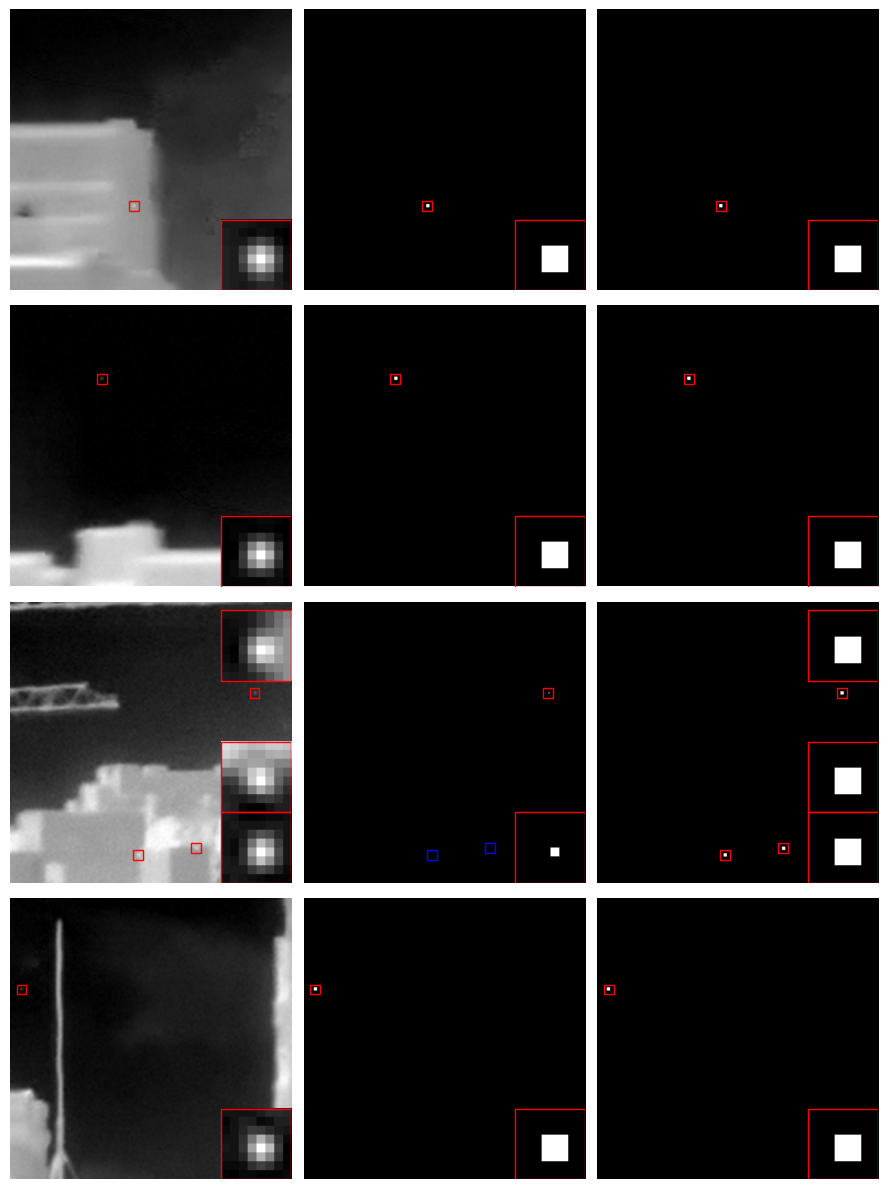

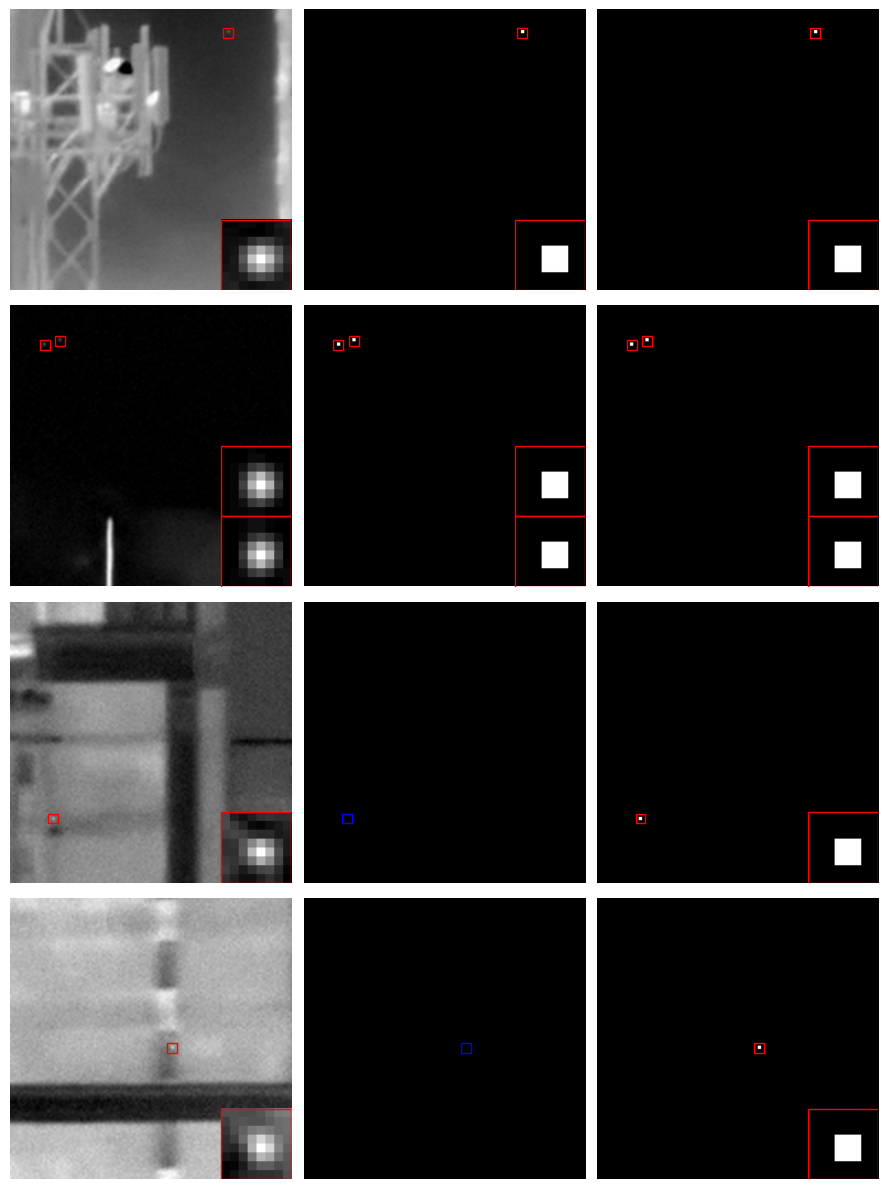

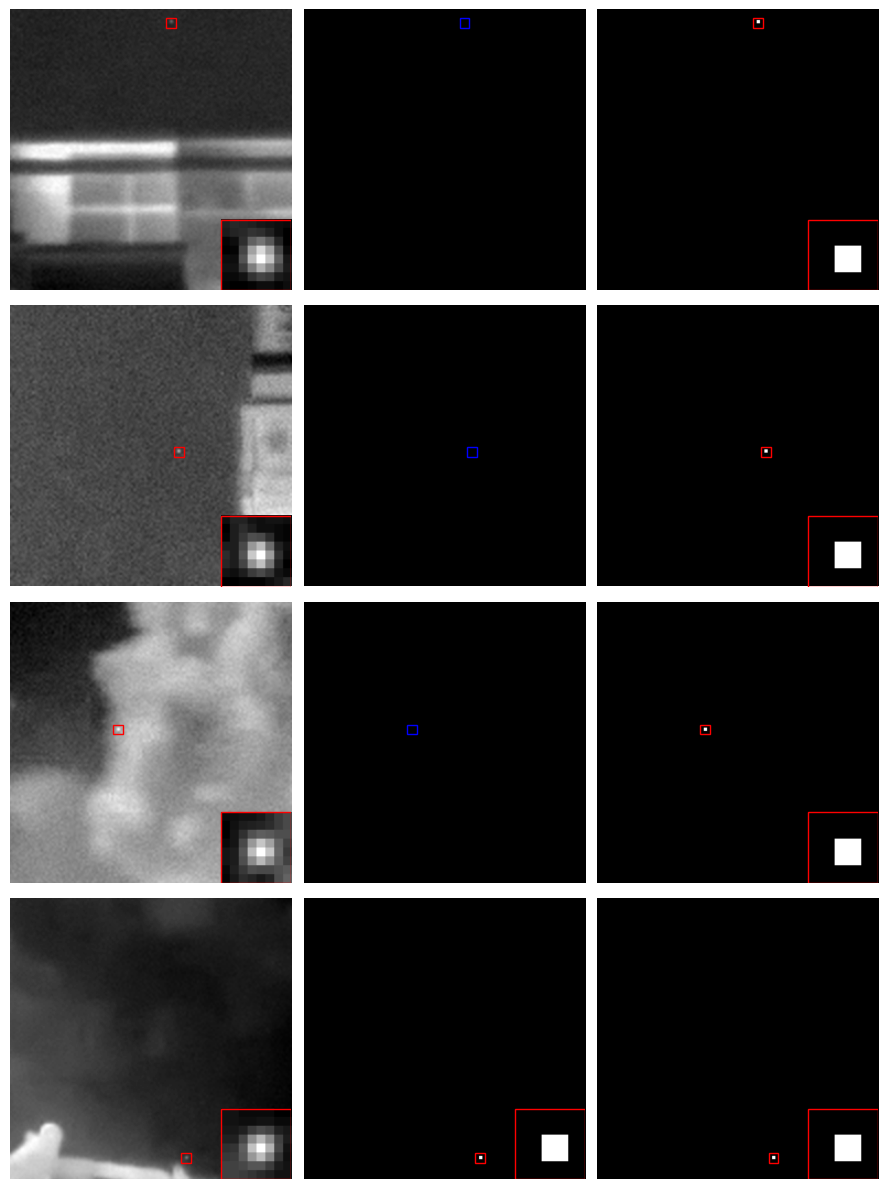

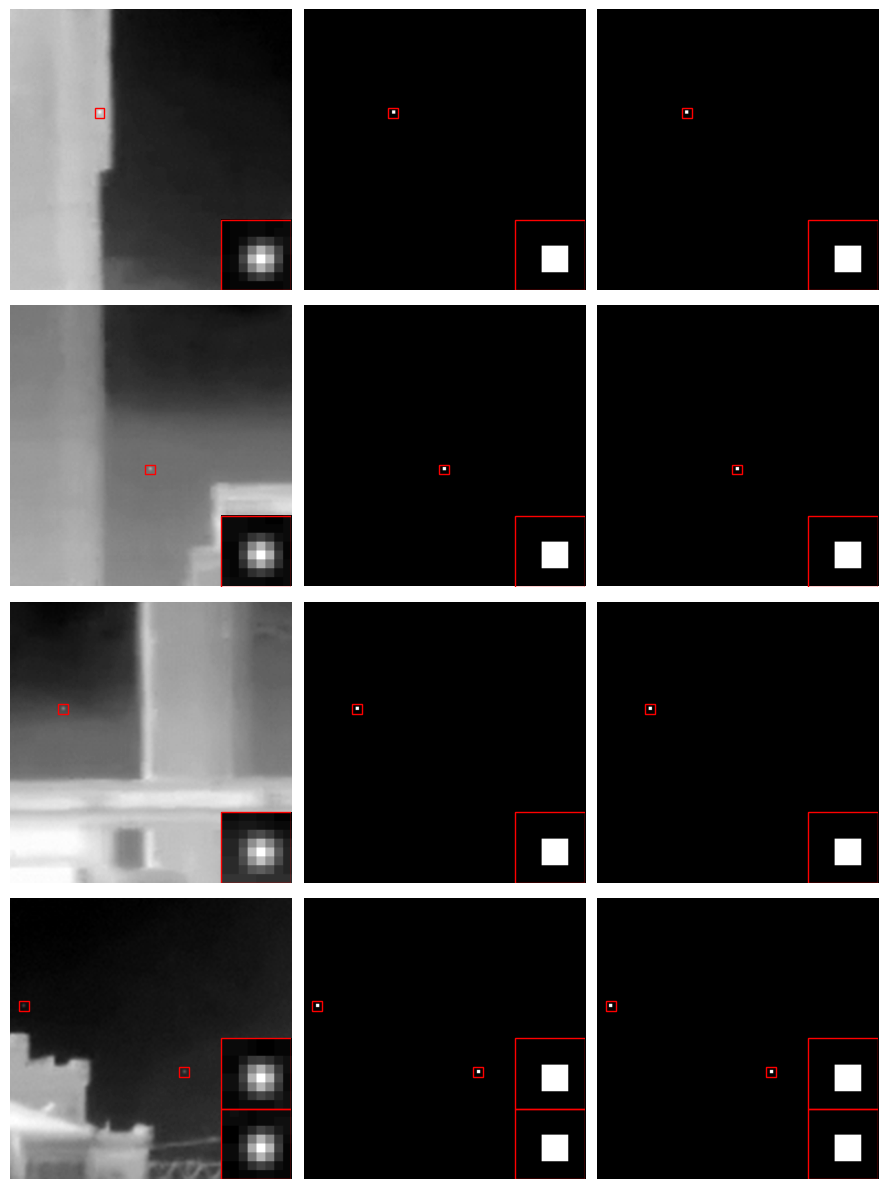

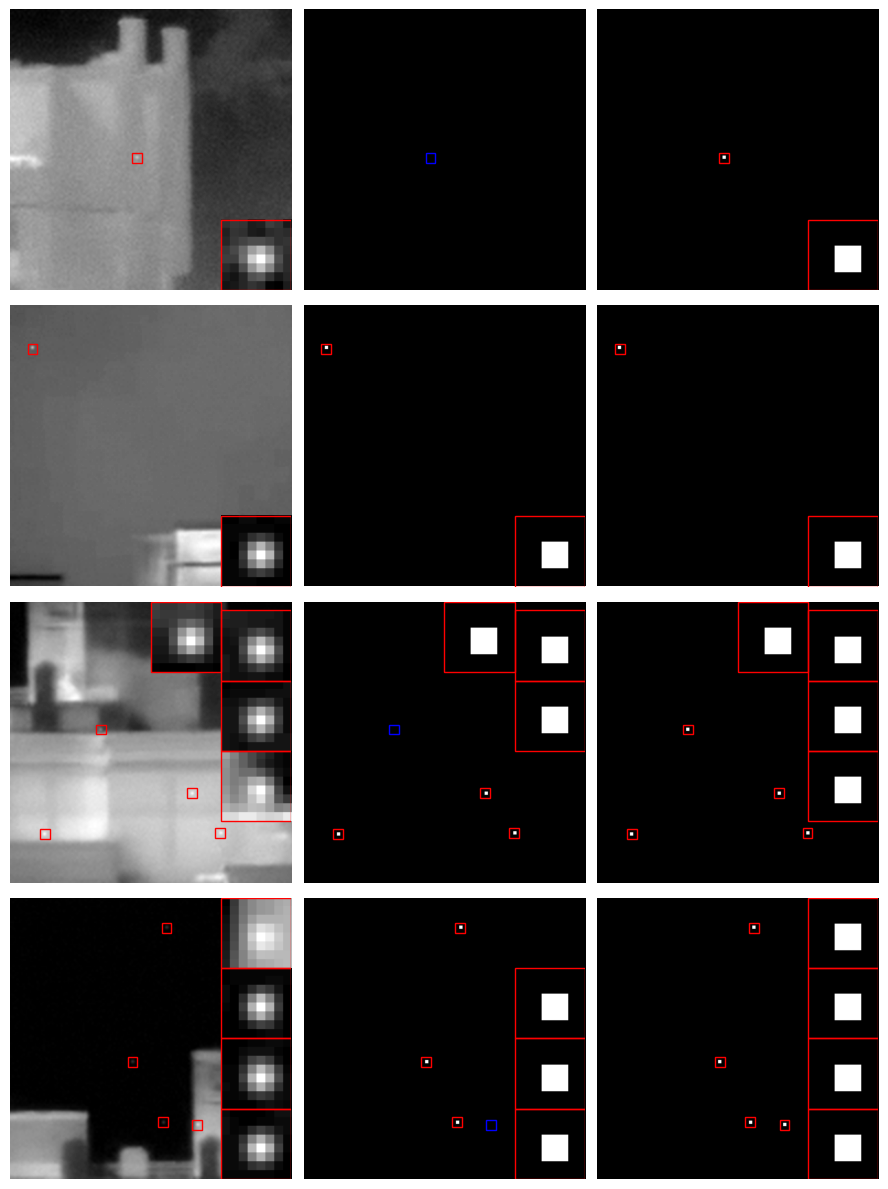

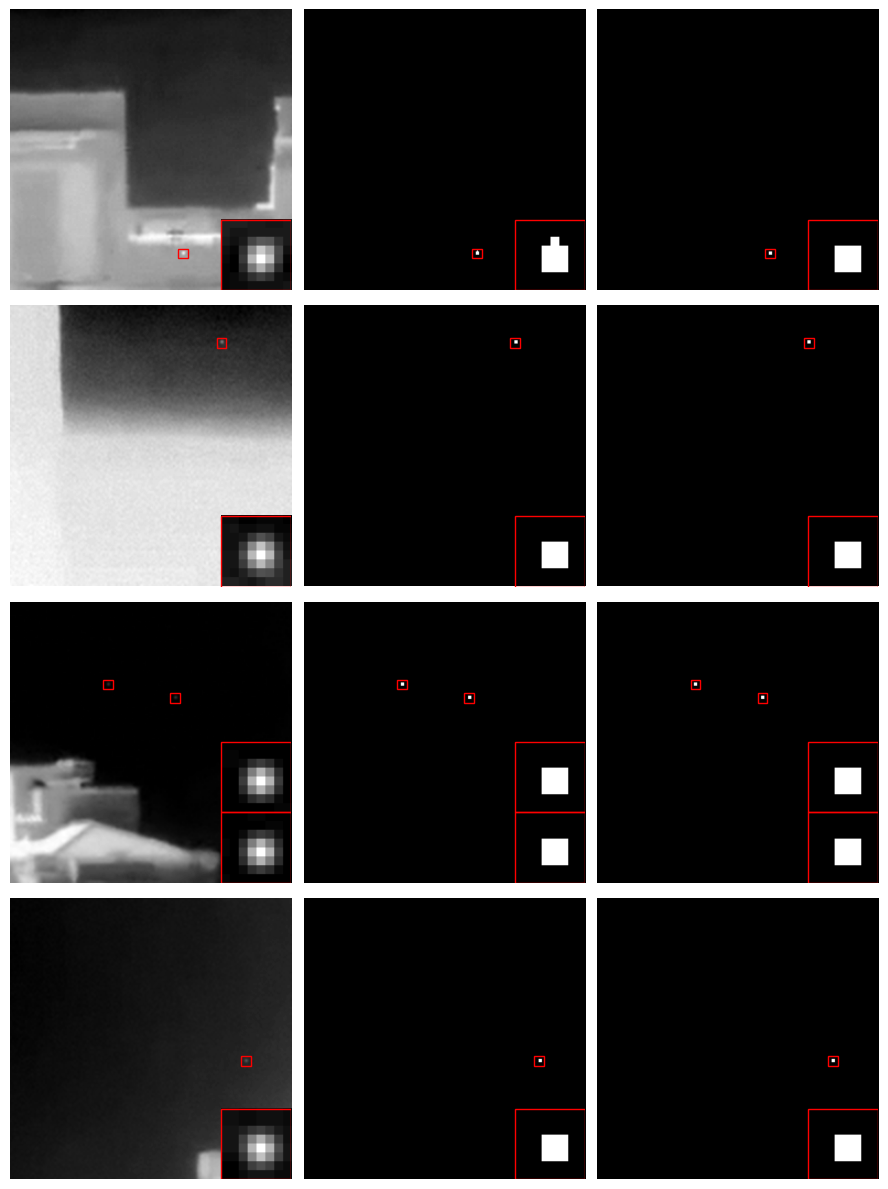

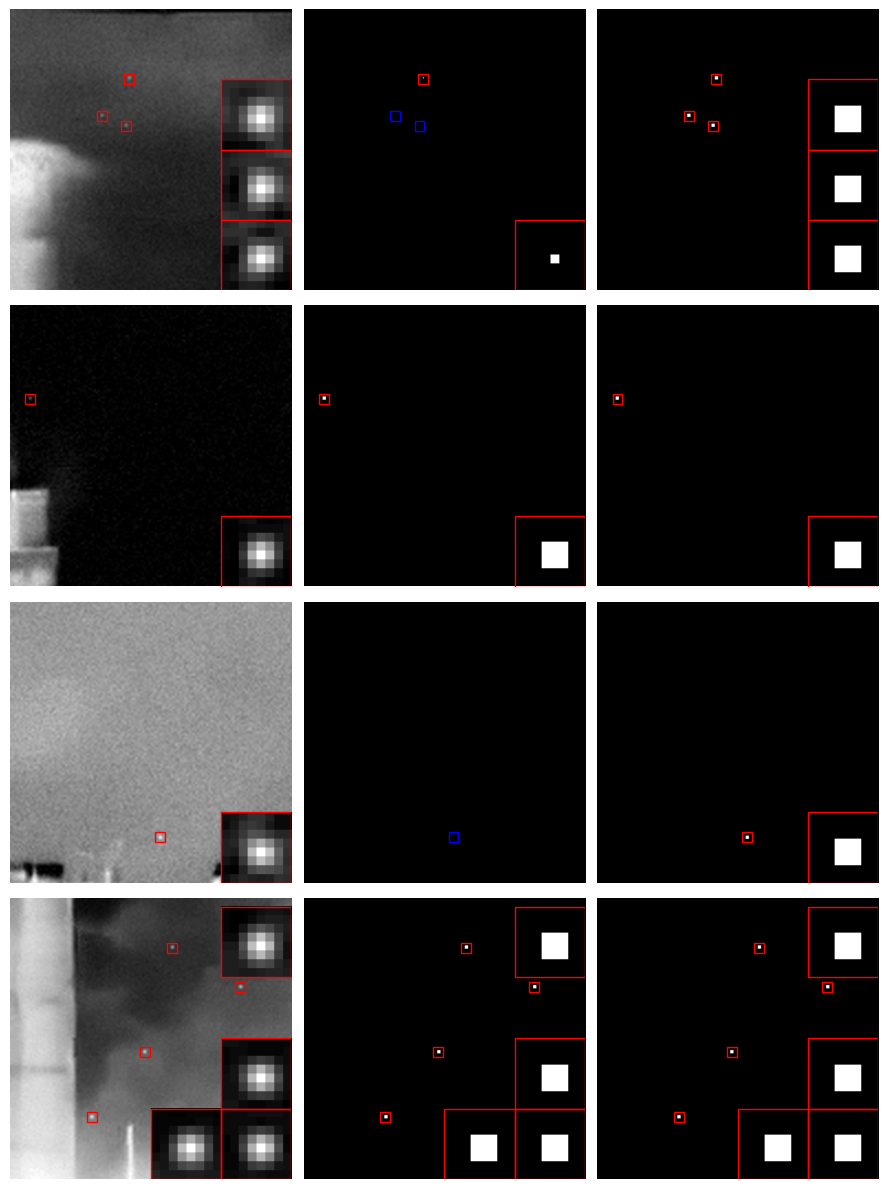

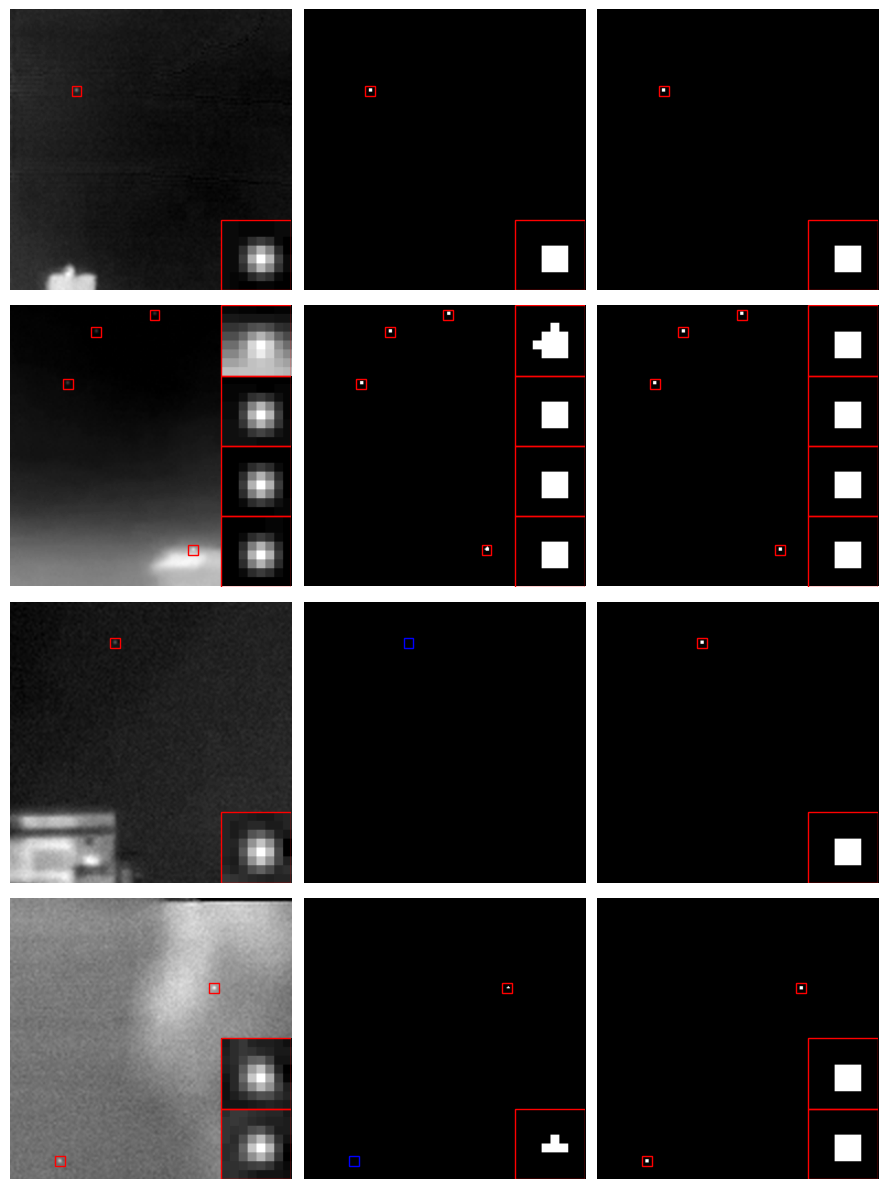

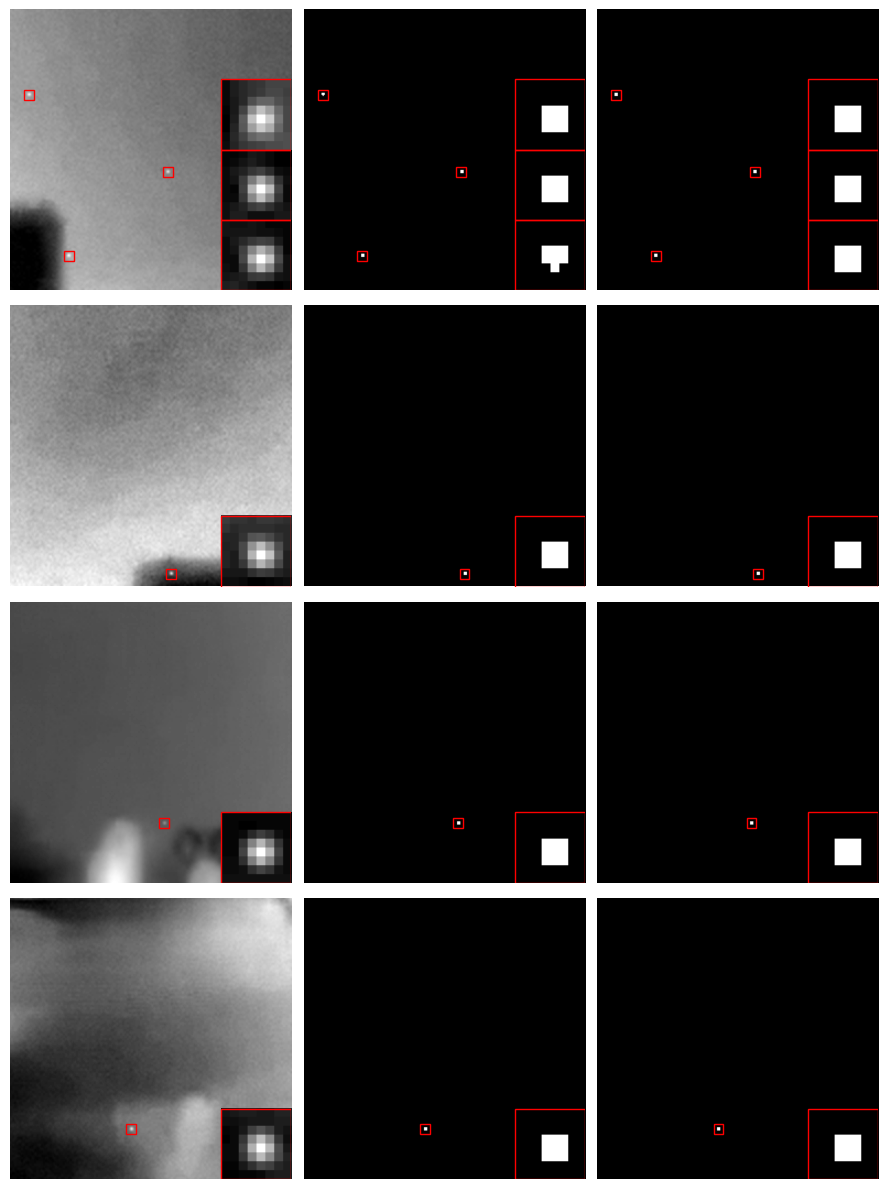

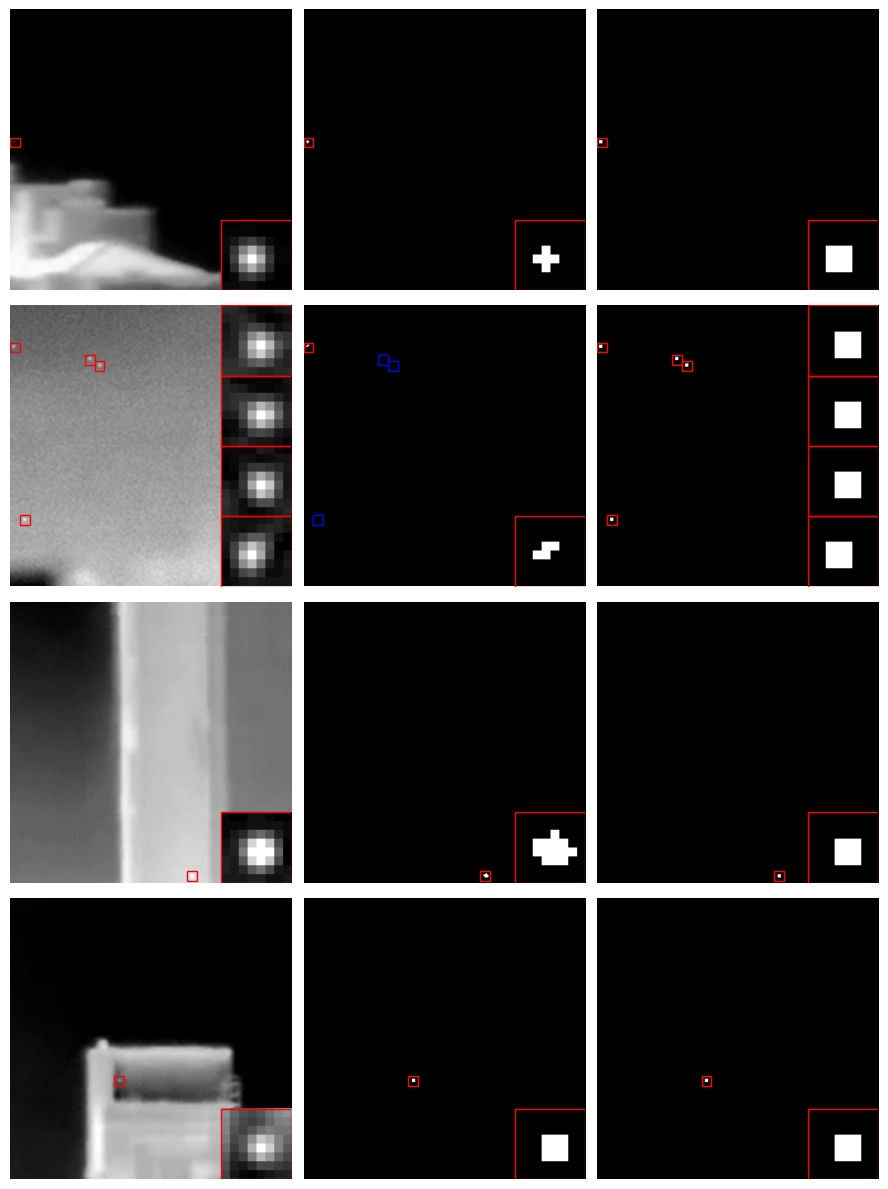

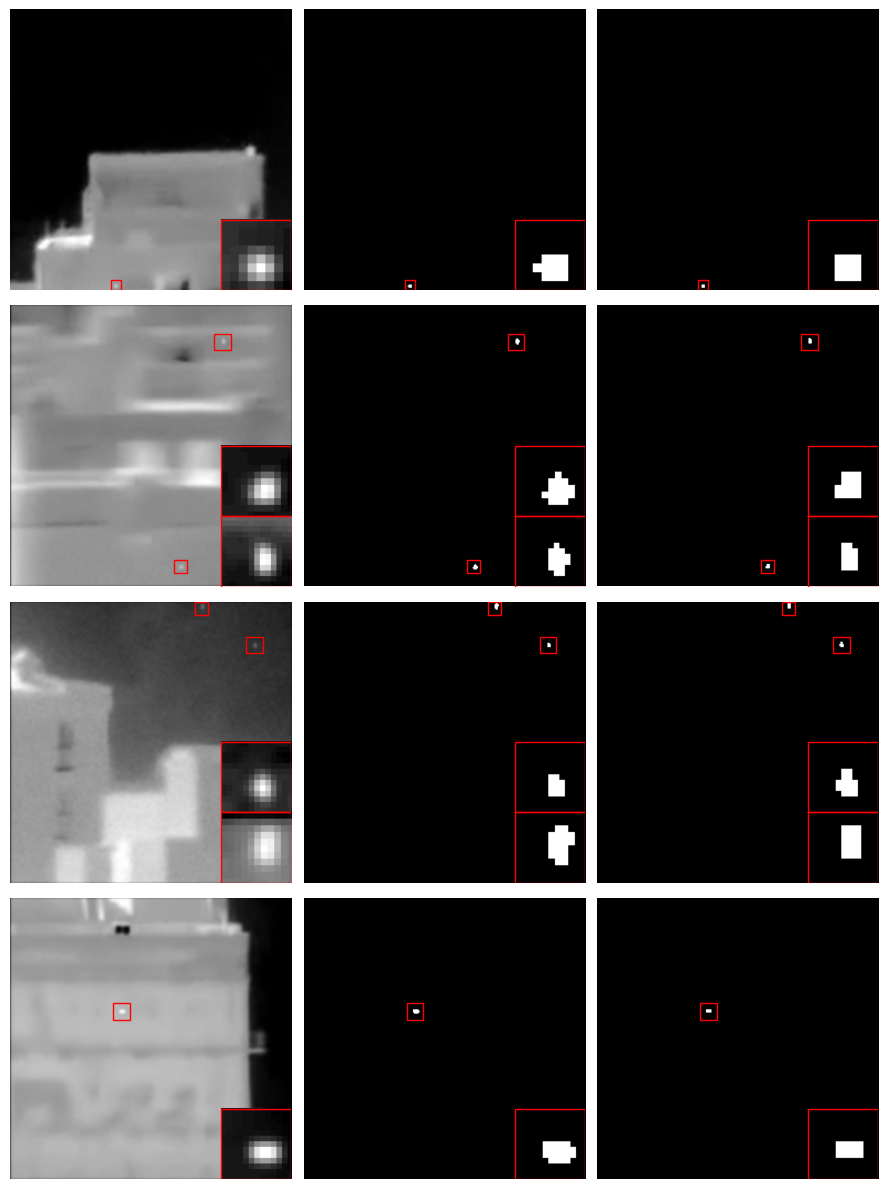

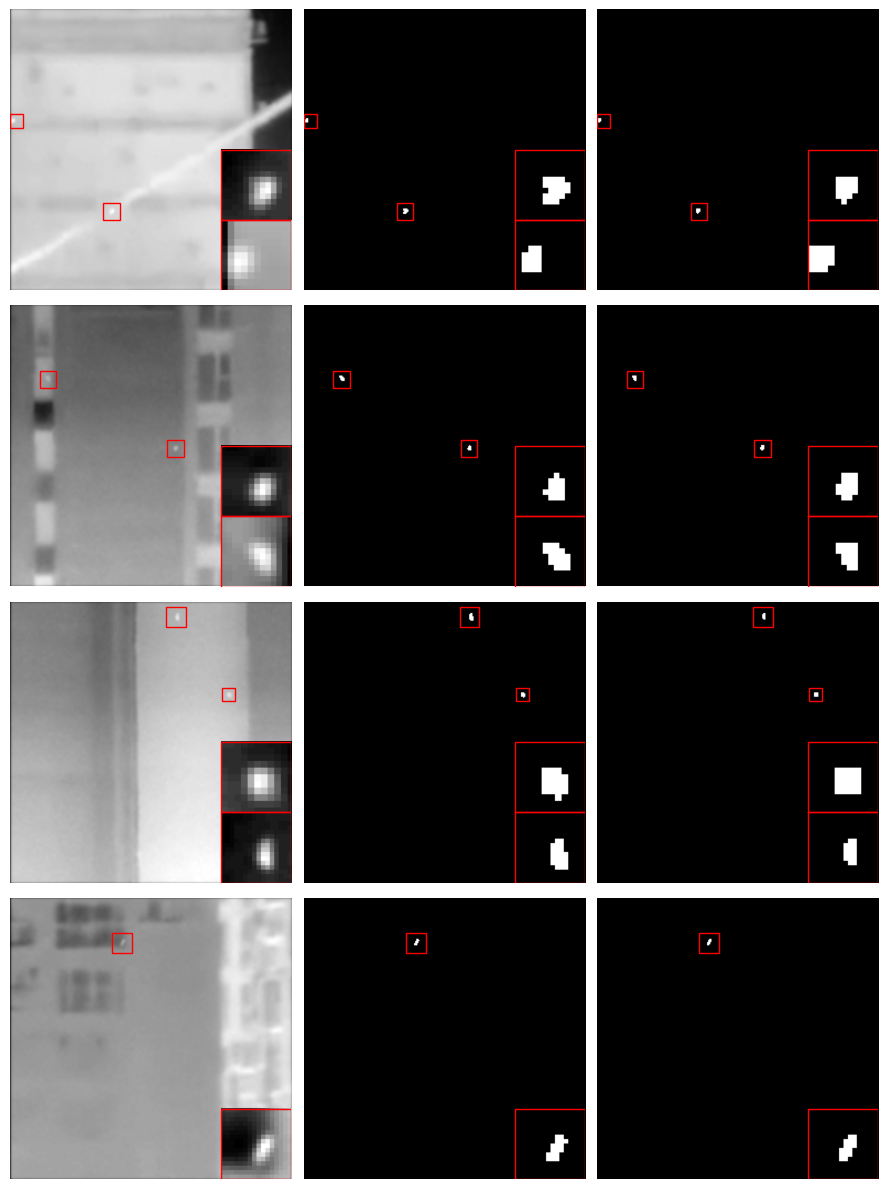

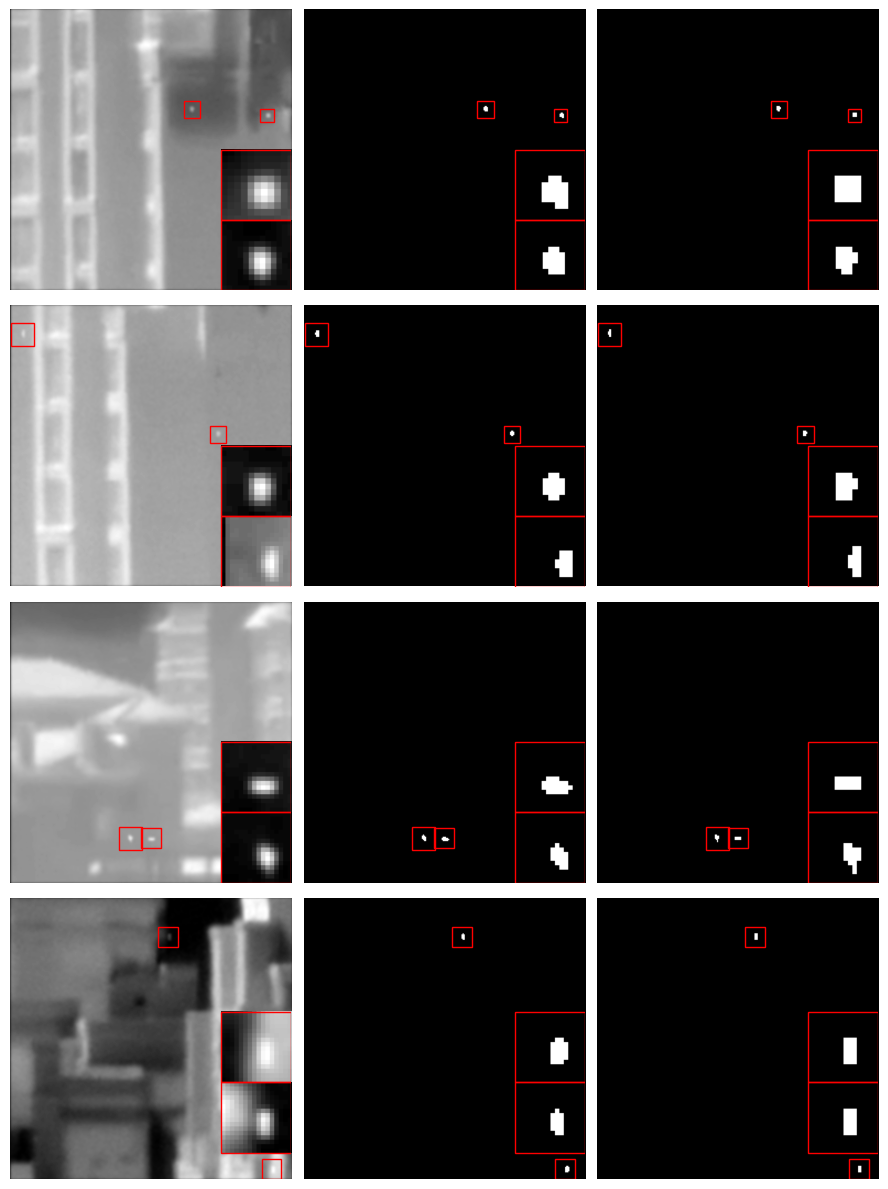

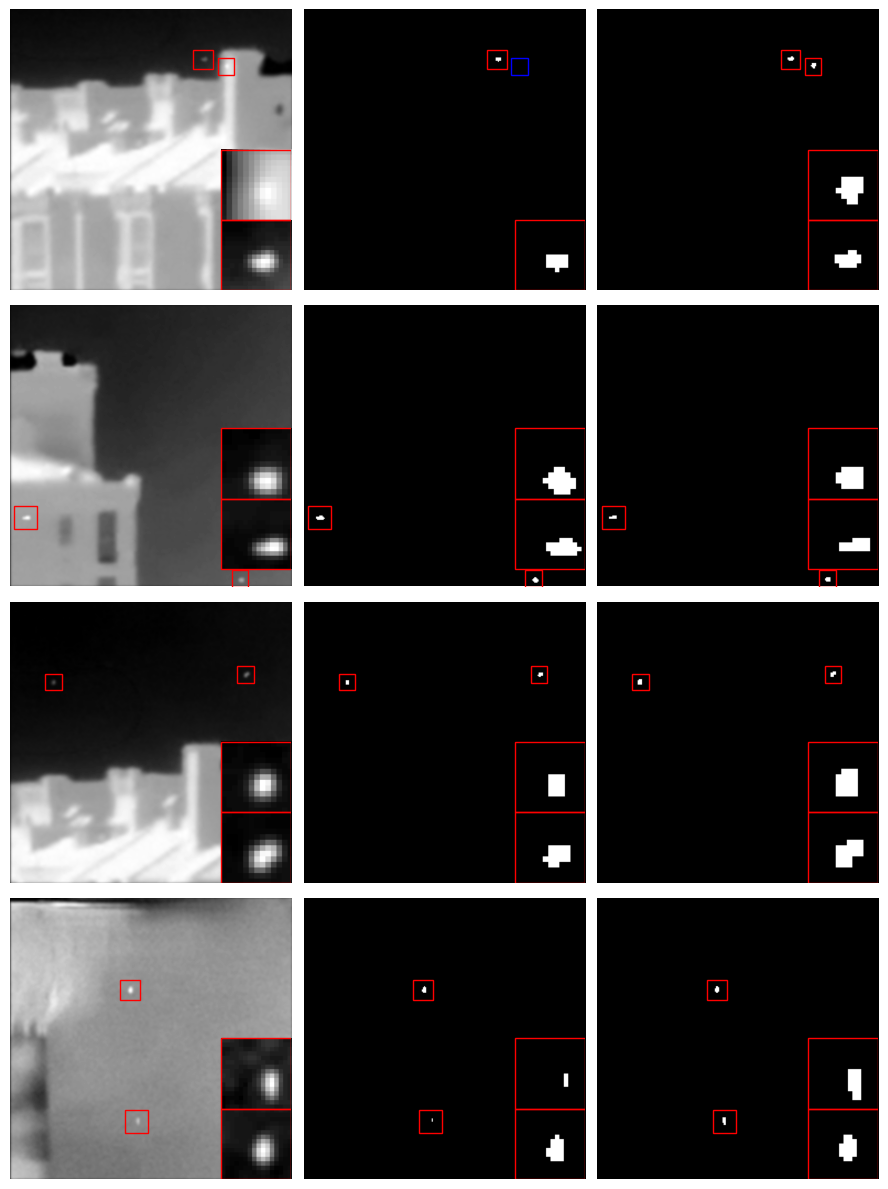

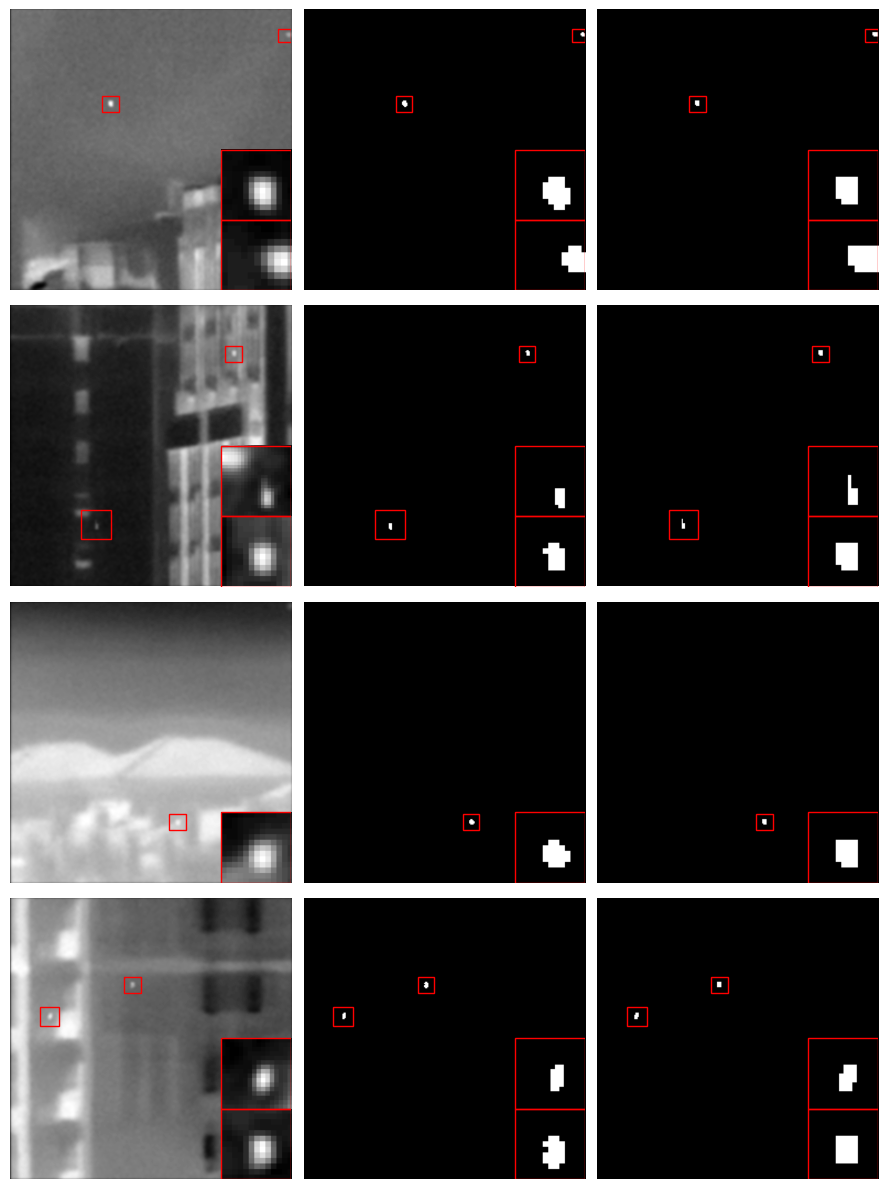

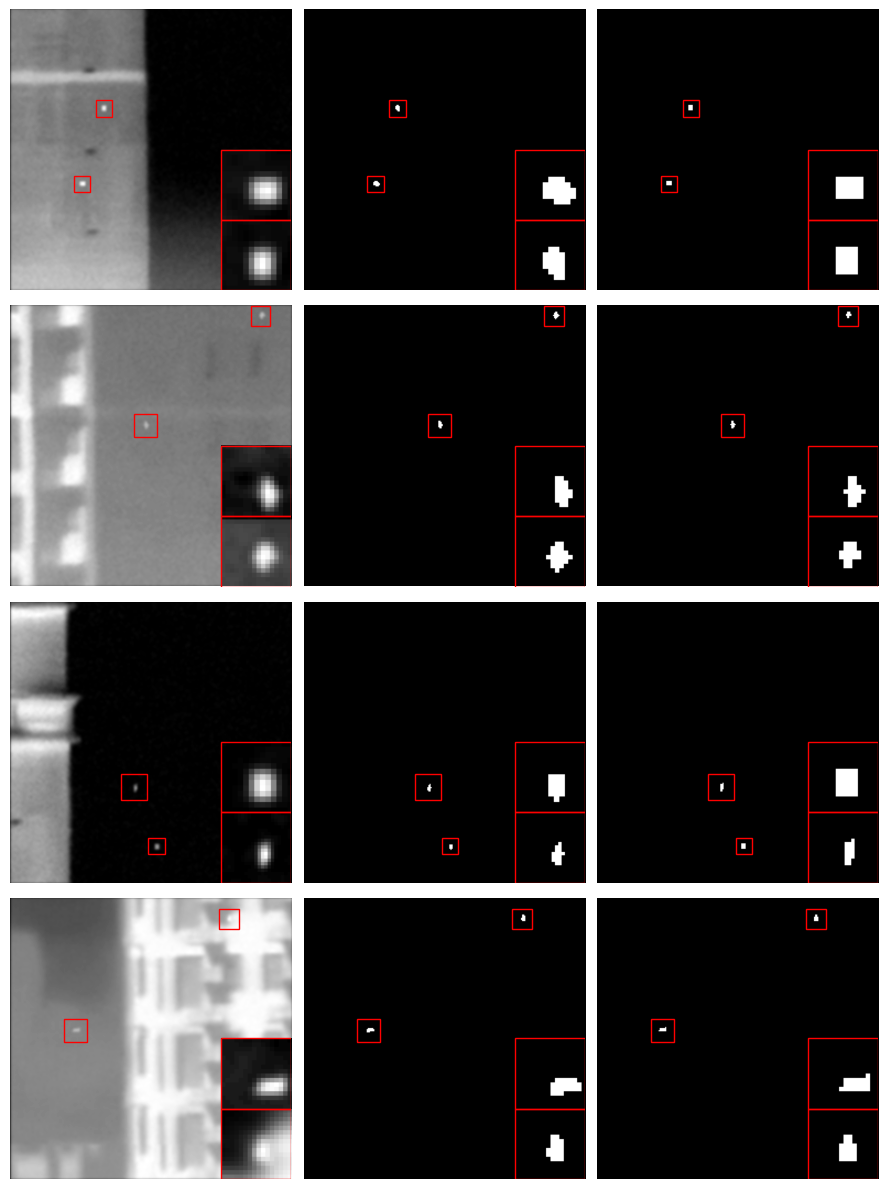

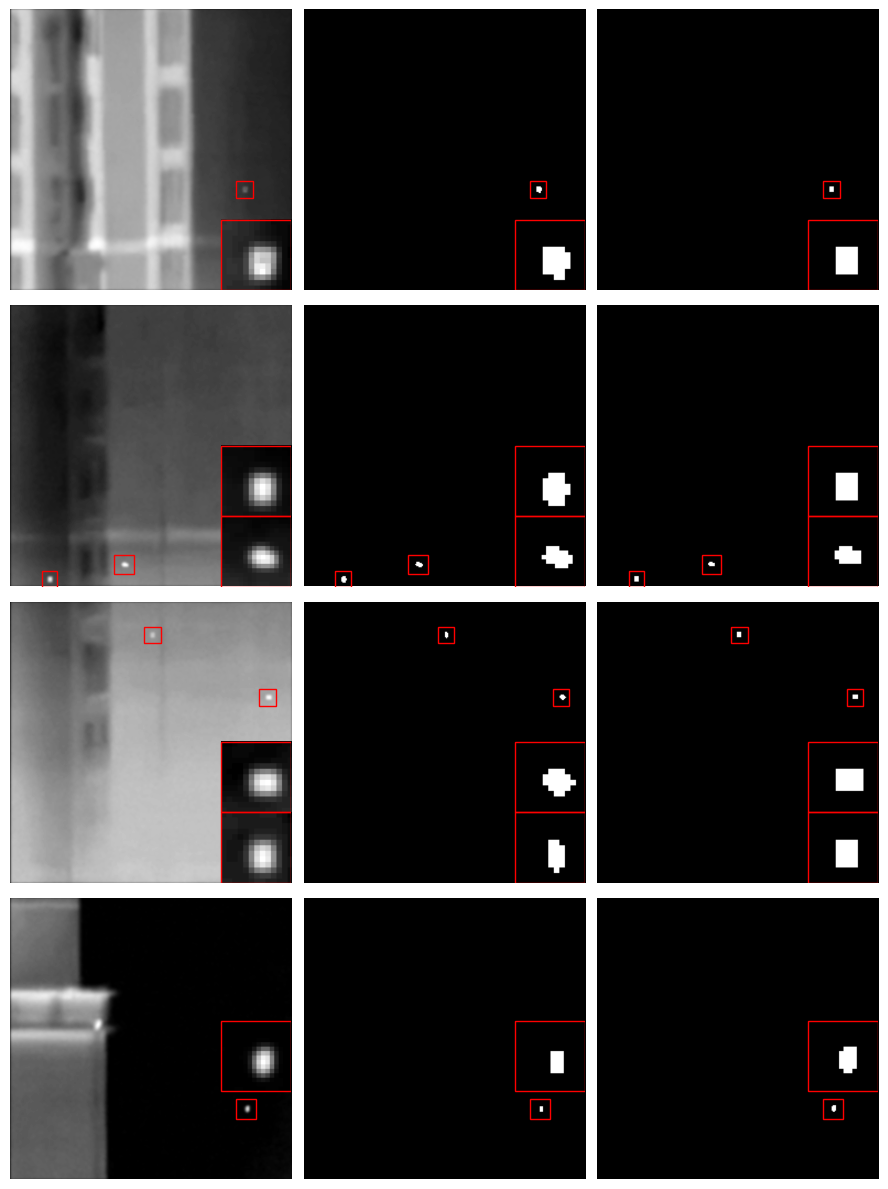

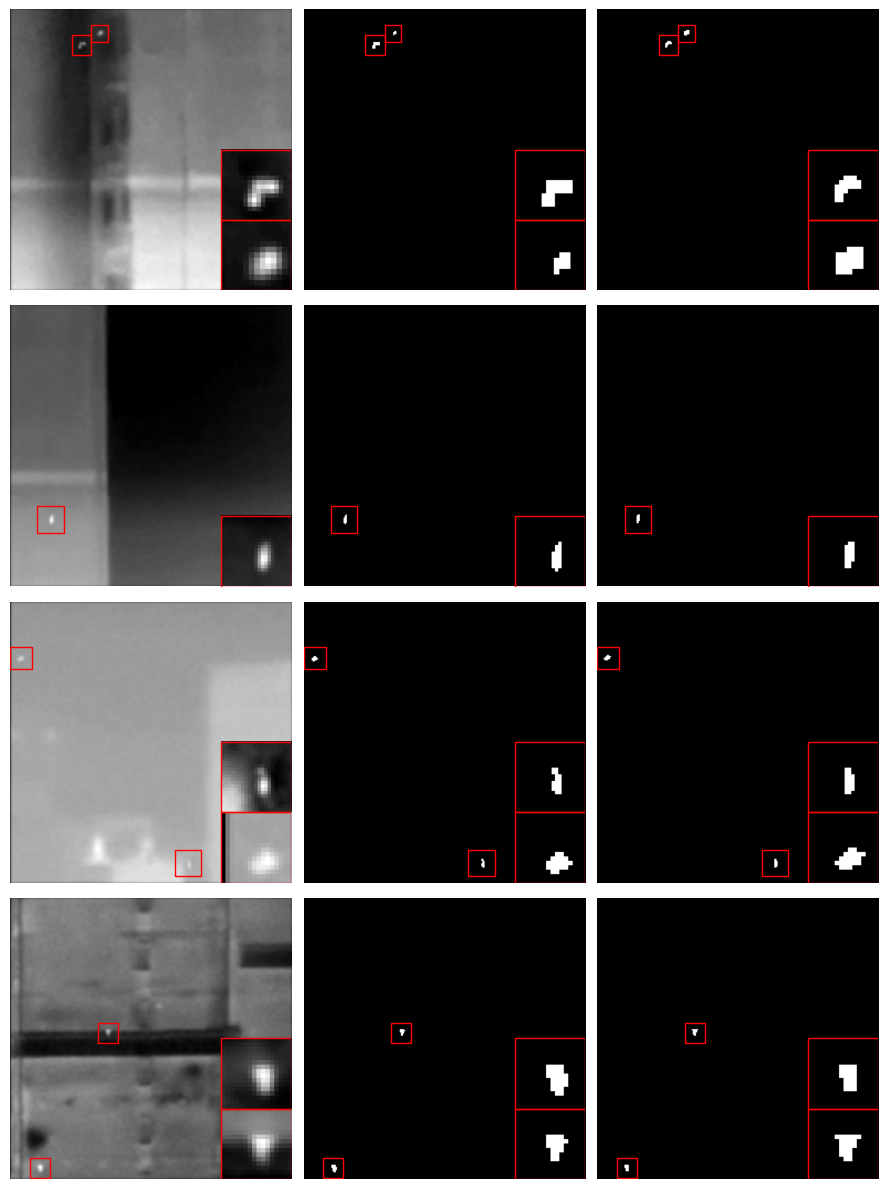

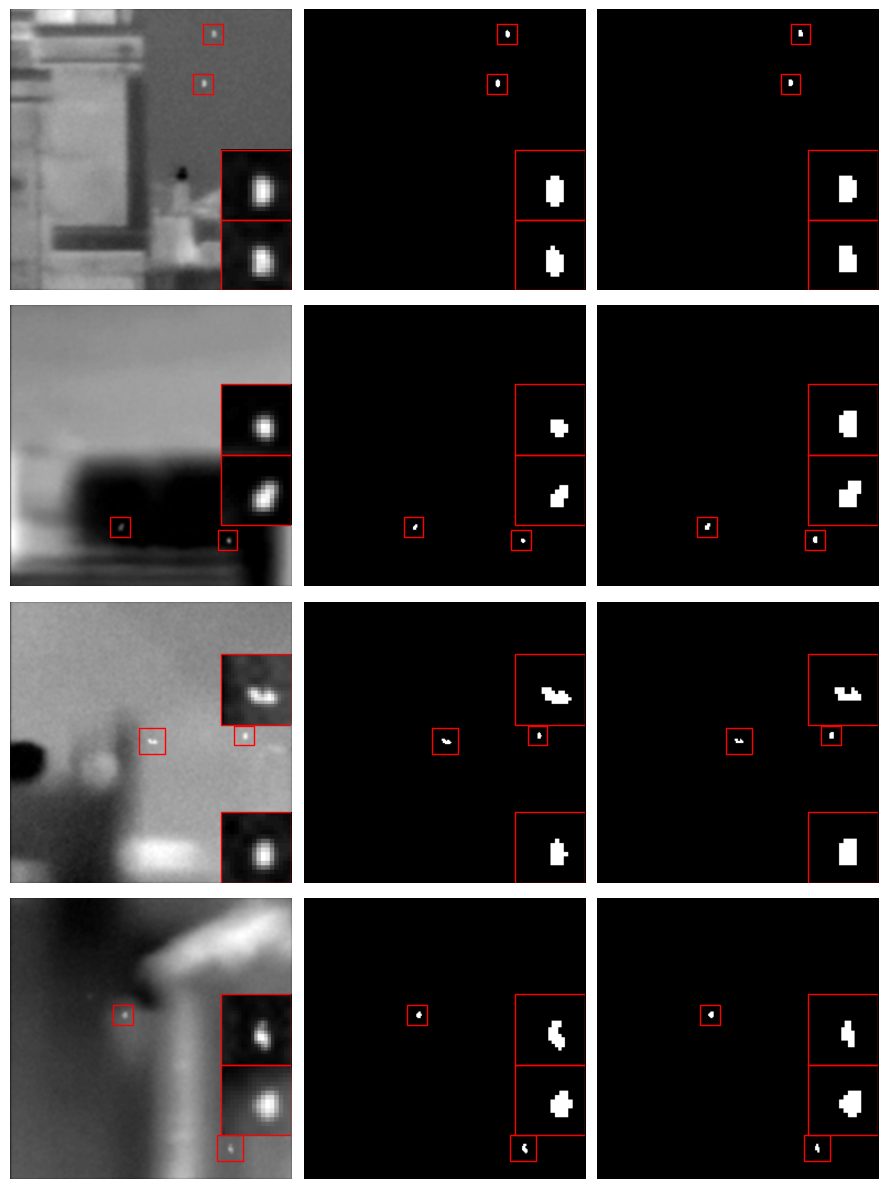

KeyboardInterrupt: Interrupted by user

In [53]:
# dataset
trainset = NUDTDataset(
    base_dir=r"W:/DataSets/ISTD/NUDT-SIRST",
    mode="test",
    base_size=256,
    pt_label=False,
    pseudo_label=0,
    preded_label=0,
    augment=False,
    turn_num=0.1,
    file_name=file_name,
)
img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images"

# trainset = MDFADataset(
#         base_dir=r"W:/DataSets/ISTD/MDvsFA",
#         mode="train",
#         base_size=128,
#         pt_label=True,
#         pseudo_label=using_pseudo_label,
#         preded_label=using_preded_label,
#         augment=False,
#         turn_num=args.last_turnnum,
#         file_name=file_name,
#     )
# img_path = "W:/DataSets/ISTD/MDvsFA/trainval/images"

# trainset = IRSTD1kDataset(
#     base_dir=r"W:/DataSets/ISTD/IRSTD-1k",
#     mode="train",
#     base_size=512,
#     pt_label=True,
#     pseudo_label=using_pseudo_label,
#     preded_label=using_preded_label,
#     augment=False,
#     turn_num=args.last_turnnum,
#     file_name=file_name,
# )
# img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"

train_data_loader = Data.DataLoader(trainset, batch_size=4, shuffle=False, drop_last=False)


# model = DNANet_withloss()
model = ASKCResUNet_withloss()
# model = AGPCNet_withloss()

model.load_state_dict(torch.load(model_path + "/best.pkl"))
model.eval()
model = model.to(device)

names = os.listdir(img_path)

# save_path = img_path + "/../" + "pixel_pseudo_label" + f"{args.save_folder}"

# # Save folders
# if not os.path.exists(save_path):
#     os.makedirs(save_path)


for j, (img, label) in enumerate(train_data_loader):
    pt_label, pesudo_label = label[:, 0:1], label[:, 1:2]
    with torch.no_grad():
        # 预测
        image_ = img.to(device)
        pred, _ = model(image_, pesudo_label.to(device))
        pred = pred.cpu()
        pred = (pred > 0.5).float()
        # pred = (pred > 0.5) * pred
        # figure = plt.figure()
        # plt.imshow(pred[0,0], cmap="gray")
        visualize_small_object_detection(img.numpy(), pred.unsqueeze(0).numpy(), label.numpy(), box_enlarge_ratio=3)
        plt.show()
        a = input()

In [1]:
def calculate_iterations(a, b, c, max_iterations=1000000):
    """
    计算经过多少次循环运算，结果才会大于c
    
    参数:
    a: 浮点数，初始参数
    b: 浮点数，权重参数
    c: 浮点数，目标阈值
    max_iterations: 最大迭代次数，防止无限循环（可选）
    
    返回:
    int: 达到结果大于c所需的迭代次数，如果无法达到则返回-1
    """
    # 边界情况检查
    if b == 0:
        # 如果b为0，结果始终为0
        return -1 if 0 <= c else 1
    
    if b == 1:
        # 如果b为1，第一次结果就是a，之后保持不变
        return 1 if a > c else -1
    
    # 初始化第一次计算
    current_result = b * a
    iterations = 1
    
    # 如果第一次就满足条件
    if current_result > c:
        return iterations
    
    # 开始循环计算
    while iterations < max_iterations:
        # 下一次计算：上次结果 * (1-b) + a * b
        current_result = current_result * (1 - b) + a * b
        iterations += 1
        
        if current_result > c:
            return iterations
    
    # 如果达到最大迭代次数仍未满足条件
    return -1

In [20]:
r = calculate_iterations(0.4, 0.75, 0.35, max_iterations=1000000)
print(r)

2


In [17]:
import torch
import numpy as np
import time

def generate_point_cloud_gpu(n_points=10000, distribution='uniform', device='cuda'):
    """生成GPU上的测试点云"""
    if distribution == 'uniform':
        points = torch.rand(n_points, 3, device=device) * 100
    elif distribution == 'gaussian':
        points = torch.randn(n_points, 3, device=device) * 20 + 50
    elif distribution == 'clusters':
        n_clusters = 5
        points_per_cluster = n_points // n_clusters
        centers = torch.tensor([[20, 20, 20], [80, 20, 20], [20, 80, 20], 
                               [80, 80, 20], [50, 50, 80]], dtype=torch.float32, device=device)
        points = []
        for i in range(n_clusters):
            cluster_points = torch.randn(points_per_cluster, 3, device=device) * 5 + centers[i]
            points.append(cluster_points)
        points = torch.cat(points, dim=0)
        if len(points) < n_points:
            extra_points = torch.rand(n_points - len(points), 3, device=device) * 100
            points = torch.cat([points, extra_points], dim=0)
    else:
        points = torch.rand(n_points, 3, device=device) * 100
    
    return points[:n_points]

def standard_fps_gpu(points, n_samples):
    """
    GPU优化的标准FPS实现
    参考CUDA代码的思路，但使用PyTorch原语
    """
    M, D = points.shape
    if n_samples >= M:
        return torch.arange(M, device=points.device)
    
    # 初始化
    selected = torch.zeros(n_samples, dtype=torch.long, device=points.device)
    selected[0] = torch.randint(0, M, (1,), device=points.device)
    
    # 使用torch.cdist计算距离，比手动计算更高效
    dists = torch.cdist(points[selected[0]:selected[0]+1], points).squeeze(0)
    
    # 贪心选择
    for i in range(1, n_samples):
        selected[i] = torch.argmax(dists)
        # 计算新选点到所有点的距离
        new_dists = torch.cdist(points[selected[i]:selected[i]+1], points).squeeze(0)
        # 更新最小距离
        dists = torch.min(dists, new_dists)
        # 避免重复选择已选点
        dists[selected[:i+1]] = -1
    
    return selected

def standard_fps_pytorch_builtin(points, n_samples):
    """
    使用PyTorch3D的FPS（如果可用）或者更优化的实现
    这里提供一个更接近CUDA实现的版本
    """
    try:
        # 如果有PyTorch3D，使用内置FPS
        from pytorch3d.ops import sample_farthest_points
        points_batch = points.unsqueeze(0)  # [1, M, 3]
        _, selected = sample_farthest_points(points_batch, K=n_samples)
        return selected.squeeze(0)
    except ImportError:
        # 回退到优化版本
        return standard_fps_gpu(points, n_samples)

def multi_stage_density_fps_gpu(points, n_samples, stage_ratios=[0.3, 0.7]):
    """
    GPU优化的多阶段基于密度的FPS
    """
    M = points.shape[0]
    device = points.device
    
    if n_samples >= M:
        return torch.arange(M, device=device)
    
    # 验证和归一化stage_ratios
    total_ratio = sum(stage_ratios)
    if abs(total_ratio - 1.0) > 1e-6:
        stage_ratios = [r / total_ratio for r in stage_ratios]
    
    # 计算每个阶段的采样数量
    stage_counts = []
    remaining = n_samples
    for i, ratio in enumerate(stage_ratios[:-1]):
        count = max(1, int(n_samples * ratio))
        count = min(count, remaining - (len(stage_ratios) - i - 1))
        stage_counts.append(count)
        remaining -= count
    stage_counts.append(remaining)
    
    # 修正总数
    while sum(stage_counts) < n_samples:
        stage_counts[-1] += 1
    while sum(stage_counts) > n_samples:
        stage_counts[-1] -= 1
    
    selected = []
    remaining_mask = torch.ones(M, dtype=torch.bool, device=device)
    
    for stage_idx, stage_n in enumerate(stage_counts):
        if stage_n <= 0:
            continue
            
        current_points = points[remaining_mask]
        current_indices = torch.nonzero(remaining_mask, as_tuple=True)[0]
        
        if len(current_points) <= stage_n:
            stage_selected_local = torch.arange(len(current_points), device=device)
        elif stage_idx == 0:
            # 第一阶段：基于全局密度
            # 使用分块计算避免内存溢出
            if len(current_points) > 3000:
                # 分块计算平均距离
                chunk_size = 2000
                avg_dists = torch.zeros(len(current_points), device=device)
                for i in range(0, len(current_points), chunk_size):
                    end_i = min(i + chunk_size, len(current_points))
                    chunk = current_points[i:end_i]
                    dist_matrix = torch.cdist(chunk, current_points)
                    avg_dists[i:end_i] = torch.mean(dist_matrix, dim=1)
            else:
                dist_matrix = torch.cdist(current_points, current_points)
                avg_dists = torch.mean(dist_matrix, dim=1)
            
            _, topk_indices = torch.topk(avg_dists, stage_n, largest=True)
            stage_selected_local = topk_indices
        else:
            # 后续阶段：选择距离已选点最远的点
            all_selected_points = torch.cat(selected_points_list) if selected else torch.empty(0, 3, device=device)
            
            if len(all_selected_points) == 0:
                stage_selected_local = torch.randperm(len(current_points), device=device)[:stage_n]
            else:
                # 分块计算距离避免内存溢出
                if len(current_points) > 3000 or len(all_selected_points) > 3000:
                    chunk_size = 2000
                    min_dists = torch.zeros(len(current_points), device=device)
                    for i in range(0, len(current_points), chunk_size):
                        end_i = min(i + chunk_size, len(current_points))
                        chunk = current_points[i:end_i]
                        dist_matrix = torch.cdist(chunk, all_selected_points)
                        min_dists[i:end_i] = torch.min(dist_matrix, dim=1)[0]
                else:
                    dist_matrix = torch.cdist(current_points, all_selected_points)
                    min_dists = torch.min(dist_matrix, dim=1)[0]
                
                _, topk_indices = torch.topk(min_dists, stage_n, largest=True)
                stage_selected_local = topk_indices
        
        # 转换为全局索引
        stage_selected_global = current_indices[stage_selected_local]
        selected.append(stage_selected_global)
        
        # 更新剩余点mask
        remaining_mask[stage_selected_global] = False
        
        # 保存已选点用于下一阶段（避免重复cat操作）
        if stage_idx == 0:
            selected_points_list = [points[stage_selected_global]]
        else:
            selected_points_list.append(points[stage_selected_global])
    
    return torch.cat(selected)

def fps_by_iou_nms_gpu_optimized(
    points: torch.Tensor,          # [M, 3] 点云坐标（GPU tensor）
    n: int,                        # 要采样的点数
    alpha: float = 0.5,
    use_adaptive_scale: bool = True,
    eps: float = 1e-8
) -> torch.Tensor:
    """
    GPU-optimized version of IoU-based FPS.
    Fully tensorized, no CPU sync, minimal memory overhead.
    """
    assert points.device.type == 'cuda', "Input points should be on GPU for optimal performance"
    assert points.dim() == 2 and points.size(1) == 3
    M = points.shape[0]
    assert 0 < n <= M

    if n == 1:
        return torch.zeros(1, dtype=torch.long, device=points.device)

    # === Step 1: Bounding box (fully on GPU) ===
    min_xyz = torch.amin(points, dim=0)   # [3]
    max_xyz = torch.amax(points, dim=0)   # [3]
    bbox_size = max_xyz - min_xyz         # [3]
    bbox_size = torch.clamp(bbox_size, min=eps)

    # === Step 2: Cube side length ===
    if use_adaptive_scale:
        scale = n ** (-1.0 / 3.0)
    else:
        scale = 1.0
    cube_side = alpha * bbox_size * scale  # [3]
    cube_side = torch.clamp(cube_side, min=eps)
    cube_vol = cube_side.prod()  # scalar

    # === Step 3: Precompute pairwise IoU_root matrix ===
    # Use broadcasting without materializing full [M, M, 3] if M is huge
    # But for M <= 10k, it's acceptable on modern GPU
    if M > 20000:
        # Optional: warn or use chunking (not implemented here for simplicity)
        pass

    # Efficient pairwise absolute difference
    # points: [M, 3] -> [M, 1, 3] and [1, M, 3]
    diff = points.unsqueeze(1) - points.unsqueeze(0)  # [M, M, 3]
    abs_diff = diff.abs_()  # in-place abs

    # Overlap length per axis
    overlap_len = cube_side - abs_diff  # [M, M, 3]
    overlap_len.clamp_(min=0.0)         # in-place clamp

    # Intersection = product over last dim
    intersection = overlap_len.prod(dim=2)  # [M, M]

    # Union = 2V - I
    union = 2.0 * cube_vol - intersection
    union.clamp_(min=eps)

    # IoU and cube root
    iou = intersection / union
    iou_root = iou.pow_(1.0 / 3.0)  # in-place power for efficiency

    # === Step 4: Greedy selection without CPU sync ===
    selected = torch.empty(n, dtype=torch.long, device=points.device)
    remaining_mask = torch.ones(M, dtype=torch.bool, device=points.device)

    # First point: argmin of total IoU
    total_iou = iou_root.sum(dim=1)  # [M]
    first_idx = torch.argmin(total_iou)
    selected[0] = first_idx
    remaining_mask[first_idx] = False

    # Pre-allocate buffer for min_iou scores
    min_iou_buffer = torch.empty(M, dtype=torch.float32, device=points.device)

    # Iteratively select remaining points
    for i in range(1, n):
        # Get IoU from all points to already selected ones
        # iou_root[:, selected[:i]] -> [M, i]
        # We only care about remaining points, but masking later is faster than indexing
        iou_to_selected = iou_root[:, selected[:i]]  # [M, i]
        
        # For each point, compute min IoU to selected set
        min_iou_all = iou_to_selected.min(dim=1).values  # [M]
        
        # Mask out already selected points (set their score to -inf so they won't be chosen)
        min_iou_buffer.copy_(min_iou_all)
        min_iou_buffer.masked_fill_(~remaining_mask, -1e9)
        
        # Select the point with maximum min-IoU (i.e., farthest)
        next_idx = torch.argmax(min_iou_buffer)
        selected[i] = next_idx
        remaining_mask[next_idx] = False

    return selected

def fps_by_iou_nms_dynamic(
    points: torch.Tensor,
    n: int,
    num_rounds: int = 5,
    round_ratios: list = None,
    alpha: float = 0.5,
    use_dynamic_box: bool = True,
    eps: float = 1e-8
) -> torch.Tensor:
    """
    GPU-optimized multi-round IoU-NMS sampling with dynamic box sizing.
    
    Args:
        points: [M, 3] float tensor
        n: number of points to sample
        num_rounds: number of sampling rounds
        round_ratios: list of length `num_rounds`, sum to 1.0
                     e.g., [0.1, 0.2, 0.2, 0.25, 0.25]
        alpha: base scale factor for box size
        use_dynamic_box: if True, adjust box size per round based on |SM|
        eps: numerical stability
    
    Returns:
        selected_indices: [n,] long tensor
    """
    assert points.dim() == 2 and points.size(1) == 3
    M = points.shape[0]
    device = points.device
    assert n <= M and n > 0

    # === Handle round ratios ===
    if round_ratios is None:
        # Equal ratios if not provided
        round_ratios = [1.0 / num_rounds] * num_rounds
    else:
        assert len(round_ratios) == num_rounds
    assert abs(sum(round_ratios) - 1.0) < 1e-5

    # Compute exact number per round (integer, last round absorbs remainder)
    round_ns = []
    remaining = n
    for i in range(num_rounds):
        if i == num_rounds - 1:
            rn = remaining
        else:
            rn = int(round(round_ratios[i] * n))
            rn = min(rn, remaining)
        round_ns.append(rn)
        remaining -= rn
        if remaining <= 0 and i < num_rounds - 1:
            round_ns = round_ns[:i+1]
            num_rounds = i + 1
            break
    round_ns = [x for x in round_ns if x > 0]
    if not round_ns:
        round_ns = [n]
        num_rounds = 1

    # === Precompute global bounding box ===
    min_xyz = points.min(dim=0).values  # [3]
    max_xyz = points.max(dim=0).values  # [3]
    bbox_size = torch.clamp(max_xyz - min_xyz, min=eps)  # [3]
    total_volume = bbox_size.prod().item()

    # === Initialize state ===
    selected_mask = torch.zeros(M, dtype=torch.bool, device=device)
    selected_indices_list = []

    # Pre-allocate candidate indices buffer
    all_indices = torch.arange(M, device=device)

    for round_idx in range(num_rounds):
        round_n = round_ns[round_idx]
        if round_n == 0:
            continue

        # === Determine SM (sparse measure set) ===
        if round_idx == 0:
            # SM = all points (dense)
            sm_points = points  # [M, 3]
            sm_size = M
        else:
            # SM = already selected points (sparse)
            sm_mask = selected_mask
            sm_points = points[sm_mask]  # [S, 3]
            sm_size = sm_points.shape[0]

        # === Determine SC (sample candidates) ===
        candidate_mask = ~selected_mask  # [M]
        candidate_points = points[candidate_mask]  # [R, 3]
        R = candidate_points.shape[0]

        if R <= round_n:
            # Take all remaining
            round_selected_local = torch.arange(R, device=device)
        else:
            # === Compute dynamic box size ===
            if use_dynamic_box:
                # Average volume per point in SM
                if sm_size > 0:
                    avg_vol_per_point = total_volume / sm_size
                    box_side = alpha * (avg_vol_per_point ** (1.0 / 3.0)) * torch.ones(3, device=device)
                else:
                    box_side = alpha * bbox_size
            else:
                # Static box: use initial scale
                box_side = alpha * bbox_size

            box_side = torch.clamp(box_side, min=eps)

            # === Compute IoU between SC and SM ===
            # candidate_points: [R, 3], sm_points: [S, 3]
            # Use broadcasting: [R, 1, 3] - [1, S, 3] -> [R, S, 3]
            diff = candidate_points.unsqueeze(1) - sm_points.unsqueeze(0)  # [R, S, 3]
            abs_diff = torch.abs(diff)  # [R, S, 3]
            
            # Compute overlap length per dimension
            overlap_len = torch.clamp(box_side - abs_diff, min=0.0)  # [R, S, 3]
            intersection = overlap_len.prod(dim=2)  # [R, S]
            box_vol = box_side.prod()  # scalar
            union = box_vol + box_vol - intersection  # [R, S]
            iou_matrix = intersection / (union + eps)  # [R, S]

            if round_idx == 0:
                # First round: score = total IoU (lower = more isolated)
                scores = iou_matrix.sum(dim=1) # [R]
                # Select round_n points with smallest scores
                _, topk_local = torch.topk(scores, round_n, largest=False)
                print(box_side)
                print(_, topk_local)
            else:
                # Subsequent rounds: for each candidate, find MIN IoU to SM
                # (smallest overlap = farthest from all selected)
                min_iou_to_sm = iou_matrix.min(dim=1).values  # [R]
                # Select round_n points with LARGEST min_iou (most isolated from SM)
                _, topk_local = torch.topk(min_iou_to_sm, round_n, largest=True)
            
            round_selected_local = topk_local

        # === Map local indices back to global ===
        candidate_global_indices = all_indices[candidate_mask]
        round_selected_global = candidate_global_indices[round_selected_local]

        # === Update state ===
        selected_mask[round_selected_global] = True
        selected_indices_list.append(round_selected_global)

        if selected_mask.sum() >= n:
            break

    # Concatenate and trim to exactly n
    final_indices = torch.cat(selected_indices_list)[:n]
    return final_indices

def gpu_optimized_nms_fps(points: torch.Tensor, n_samples: int) -> torch.Tensor:
    """
    GPU-optimized NMS-based Farthest Point Sampling
    
    Args:
        points: (N, D) tensor of point coordinates
        n_samples: number of points to sample
        
    Returns:
        selected_points: (n_samples, D) tensor of sampled points
    """
    N, D = points.shape
    
    if n_samples >= N:
        return points
    
    # 1. Compute cube side length (longest dimension of bounding box)
    min_coords = torch.min(points, dim=0, keepdim=True).values  # (1, D)
    max_coords = torch.max(points, dim=0, keepdim=True).values  # (1, D)
    bbox_range = max_coords - min_coords  # (1, D)
    cube_side = torch.max(bbox_range).item()  # scalar
    
    # 2. Compute IoU matrix efficiently
    # For axis-aligned cubes centered at each point
    half_side = cube_side / 2.0
    
    # Expand points to (N, 1, D) and (1, N, D) for pairwise computation
    points_i = points.unsqueeze(1)  # (N, 1, D)
    points_j = points.unsqueeze(0)  # (1, N, D)
    
    # Compute intersection volume
    # Intersection bounds in each dimension
    left_bound = torch.maximum(points_i - half_side, points_j - half_side)  # (N, N, D)
    right_bound = torch.minimum(points_i + half_side, points_j + half_side)  # (N, N, D)
    
    # Intersection length in each dimension
    intersection_lengths = torch.clamp(right_bound - left_bound, min=0.0)  # (N, N, D)
    
    # Handle the case where cubes don't overlap (intersection volume = 0)
    intersection_volume = torch.prod(intersection_lengths, dim=2)  # (N, N)
    
    # Cube volume (same for all cubes)
    cube_volume = cube_side ** D
    
    # Union volume = 2 * cube_volume - intersection_volume
    union_volume = 2 * cube_volume - intersection_volume
    
    # Avoid division by zero (though unlikely with same-sized cubes)
    iou_matrix = intersection_volume / torch.clamp(union_volume, min=1e-8)  # (N, N)
    
    # 3. Compute confidence scores
    # Set diagonal to 0 to ignore self-overlap
    iou_matrix_no_self = iou_matrix.clone()
    iou_matrix_no_self.fill_diagonal_(0.0)
    max_iou_per_point = torch.max(iou_matrix_no_self, dim=1).values  # (N,)
    confidence = 1.0 - max_iou_per_point  # (N,)
    
    # 4. Compute retention thresholds using broadcasting (NO LOOPS!)
    # Create confidence matrix for comparison
    conf_i = confidence.unsqueeze(1)  # (N, 1)
    conf_j = confidence.unsqueeze(0)  # (1, N)
    
    # Mask for points j that have higher confidence than point i
    higher_conf_mask = conf_j > conf_i  # (N, N)
    
    # For points with no higher confidence neighbors, set mask to False
    # and we'll handle them separately
    
    # Apply mask to IoU matrix
    masked_iou = iou_matrix.clone()
    masked_iou[~higher_conf_mask] = -1.0  # Set non-higher-conf IoUs to -1
    
    # Find maximum IoU with higher confidence points for each point
    # If no higher confidence points exist, max will be -1
    max_iou_with_higher_conf = torch.max(masked_iou, dim=1).values  # (N,)
    
    # Retention thresholds: if max_iou_with_higher_conf == -1, set to 0
    retention_thresholds = torch.where(
        max_iou_with_higher_conf == -1.0,
        torch.zeros_like(max_iou_with_higher_conf),
        max_iou_with_higher_conf
    )  # (N,)
    
    # 5. Select points with lowest retention thresholds
    _, selected_indices = torch.topk(
        retention_thresholds, 
        k=n_samples, 
        largest=False,  # smallest thresholds first
        sorted=True
    )
    
    return selected_indices

def evaluate_sampling_quality_gpu(points, sampled_indices, method_name=""):
    """GPU优化的质量评估"""
    device = points.device
    sampled_points = points[sampled_indices]
    n_samples = len(sampled_indices)
    
    # 1. 最小距离统计
    if n_samples > 1:
        if n_samples > 2000:
            # 分块计算避免内存溢出
            chunk_size = 1000
            min_distances = torch.zeros(n_samples, device=device)
            for i in range(0, n_samples, chunk_size):
                end_i = min(i + chunk_size, n_samples)
                chunk = sampled_points[i:end_i]
                dist_matrix = torch.cdist(chunk, sampled_points)
                # 设置对角线为无穷大
                for j in range(i, end_i):
                    if j < dist_matrix.shape[0]:
                        dist_matrix[j - i, sampled_indices[j]] = float('inf')
                min_distances[i:end_i] = torch.min(dist_matrix, dim=1)[0]
        else:
            dist_matrix = torch.cdist(sampled_points, sampled_points)
            dist_matrix.fill_diagonal_(float('inf'))
            min_distances = torch.min(dist_matrix, dim=1)[0]
        
        avg_min_dist = torch.mean(min_distances).item()
        min_min_dist = torch.min(min_distances).item()
    else:
        avg_min_dist = 0
        min_min_dist = 0
    
    # 2. 覆盖率
    if n_samples > 0:
        if len(points) > 5000 or n_samples > 2000:
            # 分块计算
            chunk_size = 2000
            min_dists_to_samples = torch.zeros(len(points), device=device)
            for i in range(0, len(points), chunk_size):
                end_i = min(i + chunk_size, len(points))
                chunk = points[i:end_i]
                dist_matrix = torch.cdist(chunk, sampled_points)
                min_dists_to_samples[i:end_i] = torch.min(dist_matrix, dim=1)[0]
        else:
            dist_to_samples = torch.cdist(points, sampled_points)
            min_dists_to_samples = torch.min(dist_to_samples, dim=1)[0]
        
        coverage_error = torch.mean(min_dists_to_samples).item()
        max_coverage_error = torch.max(min_dists_to_samples).item()
    else:
        coverage_error = float('inf')
        max_coverage_error = float('inf')
    
    return {
        'method': method_name,
        'n_samples': n_samples,
        'avg_min_distance': avg_min_dist,
        'min_min_distance': min_min_dist,
        'coverage_error': coverage_error,
        'max_coverage_error': max_coverage_error
    }

def compare_sampling_methods_gpu(points, n_samples, stage_ratios=[0.3, 0.7]):
    """GPU版本的比较函数"""
    print(f"点云大小: {len(points)}, 采样数量: {n_samples}")
    print(f"阶段比例: {stage_ratios}")
    print(f"设备: {points.device}")
    
    torch.cuda.synchronize()  # 确保GPU同步
    
    # 标准FPS
    start_time = time.time()
    fps_indices = standard_fps_gpu(points, n_samples)
    torch.cuda.synchronize()
    fps_time = time.time() - start_time
    
    # 多阶段方法
    torch.cuda.synchronize()
    start_time = time.time()
    # multi_stage_indices = multi_stage_density_fps_gpu(points, n_samples, stage_ratios)
    # multi_stage_indices = fps_by_iou_nms_dynamic(points, n_samples, len(stage_ratios), stage_ratios, alpha=12)
    multi_stage_indices = gpu_optimized_nms_fps(points, n_samples)
    torch.cuda.synchronize()
    multi_stage_time = time.time() - start_time
    
    # 评估质量
    fps_metrics = evaluate_sampling_quality_gpu(points, fps_indices, "Standard FPS")
    multi_stage_metrics = evaluate_sampling_quality_gpu(points, multi_stage_indices, "Multi-stage Density FPS")
    
    # 计算差异
    fps_set = set(fps_indices.cpu().tolist())
    multi_set = set(multi_stage_indices.cpu().tolist())
    intersection = len(fps_set & multi_set)
    union = len(fps_set | multi_set)
    jaccard_similarity = intersection / union if union > 0 else 0
    
    print("\n=== 性能对比 ===")
    print(f"标准FPS耗时: {fps_time:.4f}秒")
    print(f"多阶段方法耗时: {multi_stage_time:.4f}秒")
    print(f"加速比: {fps_time/multi_stage_time:.2f}x" if multi_stage_time > 0 else "N/A")
    
    print("\n=== 质量对比 ===")
    print(f"{'指标':<20} {'标准FPS':<15} {'多阶段方法':<15} {'差异':<10}")
    print("-" * 60)
    
    metrics_to_compare = ['avg_min_distance', 'min_min_distance', 'coverage_error', 'max_coverage_error']
    for metric in metrics_to_compare:
        fps_val = fps_metrics[metric]
        multi_val = multi_stage_metrics[metric]
        diff = multi_val - fps_val
        print(f"{metric:<20} {fps_val:<15.4f} {multi_val:<15.4f} {diff:<10.4f}")
    
    print(f"\nJaccard相似度: {jaccard_similarity:.4f}")
    print(f"共同选中的点数: {intersection}/{n_samples}")
    
    return {
        'fps_indices': fps_indices.cpu(),
        'multi_stage_indices': multi_stage_indices.cpu(),
        'fps_metrics': fps_metrics,
        'multi_stage_metrics': multi_stage_metrics,
        'fps_time': fps_time,
        'multi_stage_time': multi_stage_time,
        'jaccard_similarity': jaccard_similarity
    }

def run_gpu_experiment():
    """GPU实验主函数"""
    if not torch.cuda.is_available():
        print("CUDA不可用，使用CPU")
        device = 'cpu'
    else:
        device = 'cuda'
        print(f"使用GPU: {torch.cuda.get_device_name(0)}")
    
    # 生成GPU点云
    print("生成点云...")
    points = generate_point_cloud_gpu(10000, distribution='clusters', device=device)
    print(f"点云生成完成: {points.shape}")
    # print(points[:,0].min(), points[:,0].max())
    # print(points[:,1].min(), points[:,1].max())
    # print(points[:,2].min(), points[:,2].max())
    
    # 实验参数
    n_samples = 100
    stage_configs = [
        [0.2, 0.3, 0.5],
        [0.1, 0.2, 0.3, 0.4],
        [0.05, 0.1, 0.15, 0.2, 0.25, 0.25]
    ]
    
    results = {}
    
    for i, stage_ratios in enumerate(stage_configs):
        print(f"\n{'='*60}")
        print(f"实验 {i+1}: 阶段比例 {stage_ratios}")
        print('='*60)
        
        result = compare_sampling_methods_gpu(points, n_samples, stage_ratios)
        results[f"config_{i+1}"] = result
    
    return results

# 运行GPU实验
results = run_gpu_experiment()

# 自定义参数比较
print("\n" + "="*60)
print("自定义参数GPU比较")
print("="*60)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
points = generate_point_cloud_gpu(10000, distribution='uniform', device=device)
custom_result = compare_sampling_methods_gpu(
    points, 
    n_samples=300, 
    stage_ratios=[0.1, 0.2, 0.3, 0.4]
)

使用GPU: NVIDIA GeForce RTX 2080 Ti
生成点云...
点云生成完成: torch.Size([10000, 3])

实验 1: 阶段比例 [0.2, 0.3, 0.5]
点云大小: 10000, 采样数量: 100
阶段比例: [0.2, 0.3, 0.5]
设备: cuda:0

=== 性能对比 ===
标准FPS耗时: 0.0352秒
多阶段方法耗时: 0.0346秒
加速比: 1.02x

=== 质量对比 ===
指标                   标准FPS           多阶段方法           差异        
------------------------------------------------------------
avg_min_distance     11.5968         9.5570          -2.0397   
min_min_distance     10.3972         2.4453          -7.9519   
coverage_error       5.7379          9.4074          3.6695    
max_coverage_error   10.3949         15.6177         5.2227    

Jaccard相似度: 0.1976
共同选中的点数: 33/100

实验 2: 阶段比例 [0.1, 0.2, 0.3, 0.4]
点云大小: 10000, 采样数量: 100
阶段比例: [0.1, 0.2, 0.3, 0.4]
设备: cuda:0

=== 性能对比 ===
标准FPS耗时: 0.0379秒
多阶段方法耗时: 0.0354秒
加速比: 1.07x

=== 质量对比 ===
指标                   标准FPS           多阶段方法           差异        
------------------------------------------------------------
avg_min_distance     11.6638         9.5570          -2.1067 